# Informations

## One script = one condition to make it easier to follow and correct.

### I am working in local for this analysis

### This script starts by taking the variant counts csv files and concatenate them together in a long df with all the reads and other informations. 

### After, with the long dataframe containing all reads for all variants it does some quality control. Then it calculates the selection coefficient. The last steps are the heatmaps and variants categorization.

#### The goal of the script is to be a linear analysis where it's easy to find information back, so it's not made to make tests. If something is wrong at any quality control step, go in another notebook to find the problem. I open other notebooks for most quality control and if there are a lot of figures to make or other things to verify.

### 1- Wide to long dataframe
### 2- Lanes control
### 3- Selection coefficient
### 4- Replicates control
### 5- Codons control
### 6- Overlaps control
### 7- Heatmaps and figures
### 8- T-test

#### I save the dataframes along the way to be able to use them elsewhere. Dataframes and figures are saved automatically with the information given at the beginning (date+experiment).

In [52]:
##Import packages needed (and some not needed....)

import Bio

import openpyxl
from Bio import SeqIO
import os,sys,re

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter

import scipy as sp
import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_rel

pandas 1.5.2
numpy 1.23.5
matplotlib 3.4.1
scipy 1.10.0
seaborn 0.12.2


In [53]:
# Set up
# Here we can find all informations needed to run the script without changing code along the way. It limits errors.

##Condition

condition = "Posaconazole" #complete name
cond = "Posaco" #abbreviation useed in the dataframes

##date + experiment

date = "2023-12-06" #date of this analysis
date_info = "2023-06-20" #date on the reads information files
year = "2023" #year on the reads count files

experiment = "NovaSeq_winter2023_albicans"

## lists

cancel_list = [92,228, 232,233,234] #positions that did not work for any reasons

stop_list = [55,89,119,139,197,238,307,370,408,466,506] #list of stop codons in the library

#positions lists

f1_f2_over = [154,155,158,162]
f2_f3_over = [276,277,280] #275 was supposed to be there, but it's cut because of the primer
f3_f4_over = [401,402,403,404,405,406] #407 was supposed to be there, but it's cut because of the primer

over_list = [154,155,158,162,276,277,280,401,402,403,404,405,406] #all overlap

#codons

Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

DNA_Codons = {"GCT": "A", "GCC": "A", "GCA": "A", "GCG": "A","TGT": "C", "TGC": "C",
    "GAT": "D", "GAC": "D","GAA": "E", "GAG": "E","TTT": "F", "TTC": "F",
    "GGT": "G", "GGC": "G", "GGA": "G", "GGG": "G","CAT": "H", "CAC": "H","ATA": "I", "ATT": "I", "ATC": "I",
    "AAA": "K", "AAG": "K", "TTA": "L", "TTG": "L", "CTT": "L", "CTC": "L", "CTA": "L", "CTG": "L",
    "ATG": "M","AAT": "N", "AAC": "N","CCT": "P", "CCC": "P", "CCA": "P", "CCG": "P","CAA": "Q", "CAG": "Q",
    "CGT": "R", "CGC": "R", "CGA": "R", "CGG": "R", "AGA": "R", "AGG": "R","TCT": "S", "TCC": "S", "TCA": "S", 
    "TCG": "S", "AGT": "S", "AGC": "S","ACT": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "GTT": "V", "GTC": "V", "GTA": "V", "GTG": "V","TGG": "W","TAT": "Y", "TAC": "Y","TAA": "*", "TAG": "*", "TGA": "*"}

In [54]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

# 1- Wide to long dataframe

In [55]:
##taked all variant counts csv files to have a long df

##sorry this is the most horrible function I ever made (but somehow it works)

def wide_to_long(path_vari, path_info):
    
    df_info = pd.read_excel(path_info, header=0)
    df_info = df_info.sort_values(by='Name', ignore_index=True)
    
    files = [os.path.join(path_vari, i) for i in os.listdir(path_vari) if os.path.isfile(os.path.join(path_vari, i))]
    
    name_list = []
    
    # Get a list of the files names
    for name in files:
        file_name = os.path.splitext(os.path.basename(name))[0]
        name_list.append(file_name)
    
    dict_df = {}
    
    # For every file in the folder, read it and append to an empty dict
    for i in range(len(files)):
        print(str(files[i]))
        df = pd.read_csv(files[i], index_col=0)
        dict_df[name_list[i]] = df
        
    dict_melt = {}
    
    # Variants df wide to long
    for key in dict_df:
        df_reads = dict_df[key]
        dfm = df_reads.melt(ignore_index=False).reset_index()
        dfm = dfm.rename(columns={"index": "codon", "variable": "position", "value": "nbr_reads"})
        dict_melt[key] = dfm
        
    dict_df_long = {}
    inter = 0
    
    # Add the info in the long df
    for key in dict_melt:
        info = df_info

        times = len(dict_melt[key])
        con = info.iloc[inter, 3]
        tp = info.iloc[inter, 5]
        ant = info.iloc[inter, 6]
        frag = info.iloc[inter, 7]
        rep = info.iloc[inter, 8]
        la = info.iloc[inter, 9]
        OD = info.iloc[inter, 10]
        want = info.iloc[inter, 11]
        beef = info.iloc[inter, 12]
        afme = info.iloc[inter, 14]
        single = info.iloc[inter, 19]
        align = info.iloc[inter, 21]
        wt = info.iloc[inter, 22]

        chunk = pd.DataFrame({'Condition': [con], 'Timepoint': [tp], "Antifungal": [ant], "Fragment": [frag],
                              "Replicate": [rep], "Lane": [la], "OD": [OD], "reads_wanted": [want], "reads_before": [beef],
                              "reads_after_merge": [afme], "nbr_reads_single": [single], "reads_align": [align],
                              "reads_wt": [wt]})

        lala = chunk.loc[chunk.index.repeat(times)]
        lolilol = lala.reset_index()

        yay = pd.concat([dict_melt[key], lolilol], axis=1)
        print(yay)
        dict_df_long[key] = yay

        inter += 1
        
    df_list = list(dict_df_long.values())
    df_big = {}

    # Concatenate everybody together
    for i in range(len(df_list)):

        if i == 0:

            s1 = df_list[i]
            s2 = df_list[i + 1]
            df_big = pd.concat([s1, s2])
        
        elif i < len(df_list) and i != 0 and not i >= len(df_list) - 1:

            s1 = df_list[i + 1]
            df_big = pd.concat([df_big, s1], axis=0, ignore_index=True)
        
        else:
            print("The end")
        
    return df_big


In [56]:
F4_long = wide_to_long('../Variants Count/Fragment 4/',f"../Reads_info/Reads_count_CaERG11-F4_all.xlsx")
F3_long = wide_to_long('../Variants Count/Fragment 3/',f"../Reads_info/Reads_count_CaERG11-F3_all.xlsx")
F2_long = wide_to_long('../Variants Count/Fragment 2/',f"../Reads_info/Reads_count_CaERG11-F2_all.xlsx")
F1_long = wide_to_long('../Variants Count/Fragment 1/',f"../Reads_info/Reads_count_CaERG11-F1_all.xlsx")

F1_2_long = pd.concat([F1_long,F2_long],axis=0)
F3_4_long = pd.concat([F3_long, F4_long],axis=0)
All_long = pd.concat([F1_2_long, F3_4_long],axis=0)

All_long.to_csv(f'Long_df_variants_reads_final_{date}.csv')  

All_long

../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_1_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_2_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_3_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_C_2023-06-20.cs

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      401      409.0      0  CaERG11_0_Posaco_F4_C          0   
1      GCC      401      251.0      0  CaERG11_0_Posaco_F4_C          0   
2      TGC      401      238.0      0  CaERG11_0_Posaco_F4_C          0   
3      TGT      401      376.0      0  CaERG11_0_Posaco_F4_C          0   
4      GAT      401      143.0      0  CaERG11_0_Posaco_F4_C          0   
...    ...      ...        ...    ...                    ...        ...   
2062   GTC      511      191.0      0  CaERG11_0_Posaco_F4_C          0   
2063   TGG      511      322.0      0  CaERG11_0_Posaco_F4_C          0   
2064   TAC      511      328.0      0  CaERG11_0_Posaco_F4_C          0   
2065   TAT      511      214.0      0  CaERG11_0_Posaco_F4_C          0   
2066   TAA      511        NaN      0  CaERG11_0_Posaco_F4_C          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0        Posaco       

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      401        9.0      0  CaERG11_2_Vorico_F4_B          2   
1      GCC      401       12.0      0  CaERG11_2_Vorico_F4_B          2   
2      TGC      401       59.0      0  CaERG11_2_Vorico_F4_B          2   
3      TGT      401      102.0      0  CaERG11_2_Vorico_F4_B          2   
4      GAT      401        3.0      0  CaERG11_2_Vorico_F4_B          2   
...    ...      ...        ...    ...                    ...        ...   
2062   GTC      511      223.0      0  CaERG11_2_Vorico_F4_B          2   
2063   TGG      511      191.0      0  CaERG11_2_Vorico_F4_B          2   
2064   TAC      511       19.0      0  CaERG11_2_Vorico_F4_B          2   
2065   TAT      511       32.0      0  CaERG11_2_Vorico_F4_B          2   
2066   TAA      511        1.0      0  CaERG11_2_Vorico_F4_B          2   

     Antifungal Fragment Replicate  Lane         OD  reads_wanted  \
0        Vorico       F4      

The end
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_C_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_1_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_1_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_2_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_2_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_3_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_3_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Isa_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Isa_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_c

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      276      610.0      0  CaERG11_0_Itra_F3_A          0   
1      GCC      276      708.0      0  CaERG11_0_Itra_F3_A          0   
2      TGC      276      842.0      0  CaERG11_0_Itra_F3_A          0   
3      TGT      276      462.0      0  CaERG11_0_Itra_F3_A          0   
4      GAT      276      566.0      0  CaERG11_0_Itra_F3_A          0   
...    ...      ...        ...    ...                  ...        ...   
2101   GTC      406      724.0      0  CaERG11_0_Itra_F3_A          0   
2102   TGG      406      557.0      0  CaERG11_0_Itra_F3_A          0   
2103   TAC      406     1209.0      0  CaERG11_0_Itra_F3_A          0   
2104   TAT      406      483.0      0  CaERG11_0_Itra_F3_A          0   
2105   TAA      406        1.0      0  CaERG11_0_Itra_F3_A          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0          Itra       F3         A  L001  0.0 

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      276       74.0      0  CaERG11_0_Posaco_F3_B          0   
1      GCC      276      105.0      0  CaERG11_0_Posaco_F3_B          0   
2      TGC      276      142.0      0  CaERG11_0_Posaco_F3_B          0   
3      TGT      276       78.0      0  CaERG11_0_Posaco_F3_B          0   
4      GAT      276       86.0      0  CaERG11_0_Posaco_F3_B          0   
...    ...      ...        ...    ...                    ...        ...   
2101   GTC      406      107.0      0  CaERG11_0_Posaco_F3_B          0   
2102   TGG      406      109.0      0  CaERG11_0_Posaco_F3_B          0   
2103   TAC      406      178.0      0  CaERG11_0_Posaco_F3_B          0   
2104   TAT      406       92.0      0  CaERG11_0_Posaco_F3_B          0   
2105   TAA      406        NaN      0  CaERG11_0_Posaco_F3_B          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0        Posaco       

     codon position  nbr_reads  index           Condition  Timepoint  \
0      GCT      276       35.0      0  CaERG11_2_Isa_F3_C          2   
1      GCC      276       50.0      0  CaERG11_2_Isa_F3_C          2   
2      TGC      276       72.0      0  CaERG11_2_Isa_F3_C          2   
3      TGT      276       56.0      0  CaERG11_2_Isa_F3_C          2   
4      GAT      276      781.0      0  CaERG11_2_Isa_F3_C          2   
...    ...      ...        ...    ...                 ...        ...   
2101   GTC      406      300.0      0  CaERG11_2_Isa_F3_C          2   
2102   TGG      406       40.0      0  CaERG11_2_Isa_F3_C          2   
2103   TAC      406      524.0      0  CaERG11_2_Isa_F3_C          2   
2104   TAT      406      194.0      0  CaERG11_2_Isa_F3_C          2   
2105   TAA      406        1.0      0  CaERG11_2_Isa_F3_C          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0           Isa       F3         C  L001  10.80919       5000000   

The end
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_C_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_1_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_1_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_2_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_2_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_3_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_3_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Isa_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Isa_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_c

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      154      712.0      0  CaERG11_0_Itra_F2_C          0   
1      GCC      154     1002.0      0  CaERG11_0_Itra_F2_C          0   
2      TGC      154     1489.0      0  CaERG11_0_Itra_F2_C          0   
3      TGT      154     1024.0      0  CaERG11_0_Itra_F2_C          0   
4      GAT      154     1700.0      0  CaERG11_0_Itra_F2_C          0   
...    ...      ...        ...    ...                  ...        ...   
1360   GTC      280     1260.0      0  CaERG11_0_Itra_F2_C          0   
1361   TGG      280     1367.0      0  CaERG11_0_Itra_F2_C          0   
1362   TAC      280      793.0      0  CaERG11_0_Itra_F2_C          0   
1363   TAT      280      694.0      0  CaERG11_0_Itra_F2_C          0   
1364   TAA      280        2.0      0  CaERG11_0_Itra_F2_C          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0          Itra       F2         C  L001  0.0 

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      154      533.0      0  CaERG11_0_Vorico_F2_C          0   
1      GCC      154      730.0      0  CaERG11_0_Vorico_F2_C          0   
2      TGC      154     1247.0      0  CaERG11_0_Vorico_F2_C          0   
3      TGT      154      701.0      0  CaERG11_0_Vorico_F2_C          0   
4      GAT      154     1288.0      0  CaERG11_0_Vorico_F2_C          0   
...    ...      ...        ...    ...                    ...        ...   
1360   GTC      280      935.0      0  CaERG11_0_Vorico_F2_C          0   
1361   TGG      280      943.0      0  CaERG11_0_Vorico_F2_C          0   
1362   TAC      280      658.0      0  CaERG11_0_Vorico_F2_C          0   
1363   TAT      280      505.0      0  CaERG11_0_Vorico_F2_C          0   
1364   TAA      280        4.0      0  CaERG11_0_Vorico_F2_C          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0        Vorico       

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      154     1697.0      0  CaERG11_2_Vorico_F2_C          2   
1      GCC      154     2446.0      0  CaERG11_2_Vorico_F2_C          2   
2      TGC      154     2193.0      0  CaERG11_2_Vorico_F2_C          2   
3      TGT      154     1351.0      0  CaERG11_2_Vorico_F2_C          2   
4      GAT      154      295.0      0  CaERG11_2_Vorico_F2_C          2   
...    ...      ...        ...    ...                    ...        ...   
1360   GTC      280       70.0      0  CaERG11_2_Vorico_F2_C          2   
1361   TGG      280     4871.0      0  CaERG11_2_Vorico_F2_C          2   
1362   TAC      280       15.0      0  CaERG11_2_Vorico_F2_C          2   
1363   TAT      280       19.0      0  CaERG11_2_Vorico_F2_C          2   
1364   TAA      280        5.0      0  CaERG11_2_Vorico_F2_C          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0        Vorico       F2       

The end
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_A_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_B_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_C_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_1_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_1_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_2_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_2_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_3_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_3_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Isa_F1_A_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Isa_F1_B_2023-06-20.csv
../Variants Count/Fragment 1/Variants_c

     codon position  nbr_reads  index             Condition  Timepoint  \
0      GCT       55      423.0      0  CaERG11_0_Fluco_F1_1          0   
1      GCC       55      296.0      0  CaERG11_0_Fluco_F1_1          0   
2      TGC       55      401.0      0  CaERG11_0_Fluco_F1_1          0   
3      TGT       55      480.0      0  CaERG11_0_Fluco_F1_1          0   
4      GAT       55      553.0      0  CaERG11_0_Fluco_F1_1          0   
...    ...      ...        ...    ...                   ...        ...   
2998   GTC      162      343.0      0  CaERG11_0_Fluco_F1_1          0   
2999   TGG      162      489.0      0  CaERG11_0_Fluco_F1_1          0   
3000   TAC      162      454.0      0  CaERG11_0_Fluco_F1_1          0   
3001   TAT      162      490.0      0  CaERG11_0_Fluco_F1_1          0   
3002   TAA      162        2.0      0  CaERG11_0_Fluco_F1_1          0   

     Antifungal Fragment  Replicate  Lane    OD  reads_wanted  reads_before  \
0         Fluco       F1        

     codon position  nbr_reads  index           Condition  Timepoint  \
0      GCT       55      223.0      0  CaERG11_0_Isa_F1_C          0   
1      GCC       55      135.0      0  CaERG11_0_Isa_F1_C          0   
2      TGC       55      191.0      0  CaERG11_0_Isa_F1_C          0   
3      TGT       55      204.0      0  CaERG11_0_Isa_F1_C          0   
4      GAT       55      249.0      0  CaERG11_0_Isa_F1_C          0   
...    ...      ...        ...    ...                 ...        ...   
2998   GTC      162      168.0      0  CaERG11_0_Isa_F1_C          0   
2999   TGG      162      270.0      0  CaERG11_0_Isa_F1_C          0   
3000   TAC      162      217.0      0  CaERG11_0_Isa_F1_C          0   
3001   TAT      162      250.0      0  CaERG11_0_Isa_F1_C          0   
3002   TAA      162        1.0      0  CaERG11_0_Isa_F1_C          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0           Isa       F1         C  L001  0.0       500000

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT       55      530.0      0  CaERG11_0_None_F1_3          0   
1      GCC       55      364.0      0  CaERG11_0_None_F1_3          0   
2      TGC       55      461.0      0  CaERG11_0_None_F1_3          0   
3      TGT       55      570.0      0  CaERG11_0_None_F1_3          0   
4      GAT       55      645.0      0  CaERG11_0_None_F1_3          0   
...    ...      ...        ...    ...                  ...        ...   
2998   GTC      162      374.0      0  CaERG11_0_None_F1_3          0   
2999   TGG      162      630.0      0  CaERG11_0_None_F1_3          0   
3000   TAC      162      495.0      0  CaERG11_0_None_F1_3          0   
3001   TAT      162      608.0      0  CaERG11_0_None_F1_3          0   
3002   TAA      162        1.0      0  CaERG11_0_None_F1_3          0   

     Antifungal Fragment  Replicate  Lane    OD  reads_wanted  reads_before  \
0          None       F1          3  L001  7

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT       55      242.0      0  CaERG11_0_Vorico_F1_B          0   
1      GCC       55      118.0      0  CaERG11_0_Vorico_F1_B          0   
2      TGC       55      164.0      0  CaERG11_0_Vorico_F1_B          0   
3      TGT       55      277.0      0  CaERG11_0_Vorico_F1_B          0   
4      GAT       55      286.0      0  CaERG11_0_Vorico_F1_B          0   
...    ...      ...        ...    ...                    ...        ...   
2998   GTC      162      186.0      0  CaERG11_0_Vorico_F1_B          0   
2999   TGG      162      254.0      0  CaERG11_0_Vorico_F1_B          0   
3000   TAC      162      240.0      0  CaERG11_0_Vorico_F1_B          0   
3001   TAT      162      210.0      0  CaERG11_0_Vorico_F1_B          0   
3002   TAA      162        NaN      0  CaERG11_0_Vorico_F1_B          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0        Vorico       

     codon position  nbr_reads  index             Condition  Timepoint  \
0      GCT       55      201.0      0  CaERG11_2_Fluco_F1_2          2   
1      GCC       55      143.0      0  CaERG11_2_Fluco_F1_2          2   
2      TGC       55      257.0      0  CaERG11_2_Fluco_F1_2          2   
3      TGT       55      273.0      0  CaERG11_2_Fluco_F1_2          2   
4      GAT       55        7.0      0  CaERG11_2_Fluco_F1_2          2   
...    ...      ...        ...    ...                   ...        ...   
2998   GTC      162      194.0      0  CaERG11_2_Fluco_F1_2          2   
2999   TGG      162      424.0      0  CaERG11_2_Fluco_F1_2          2   
3000   TAC      162      457.0      0  CaERG11_2_Fluco_F1_2          2   
3001   TAT      162      580.0      0  CaERG11_2_Fluco_F1_2          2   
3002   TAA      162        NaN      0  CaERG11_2_Fluco_F1_2          2   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0         Fluco       F1          2  L002 

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT       55      158.0      0  CaERG11_2_Vorico_F1_A          2   
1      GCC       55       68.0      0  CaERG11_2_Vorico_F1_A          2   
2      TGC       55      221.0      0  CaERG11_2_Vorico_F1_A          2   
3      TGT       55      127.0      0  CaERG11_2_Vorico_F1_A          2   
4      GAT       55       10.0      0  CaERG11_2_Vorico_F1_A          2   
...    ...      ...        ...    ...                    ...        ...   
2998   GTC      162      363.0      0  CaERG11_2_Vorico_F1_A          2   
2999   TGG      162      193.0      0  CaERG11_2_Vorico_F1_A          2   
3000   TAC      162      285.0      0  CaERG11_2_Vorico_F1_A          2   
3001   TAT      162      410.0      0  CaERG11_2_Vorico_F1_A          2   
3002   TAA      162        NaN      0  CaERG11_2_Vorico_F1_A          2   

     Antifungal Fragment Replicate  Lane       OD  reads_wanted  reads_before  \
0        Vorico   

The end


codon position  nbr_reads  index              Condition  Timepoint  \
0       GCT       55      528.0      0  CaERG11_0_Clotri_F1_A          0   
1       GCC       55      386.0      0  CaERG11_0_Clotri_F1_A          0   
2       TGC       55      532.0      0  CaERG11_0_Clotri_F1_A          0   
3       TGT       55      601.0      0  CaERG11_0_Clotri_F1_A          0   
4       GAT       55      628.0      0  CaERG11_0_Clotri_F1_A          0   
...     ...      ...        ...    ...                    ...        ...   
99211   GTC      511      235.0      0    CaERG11_3_None_F4_3          3   
99212   TGG      511      293.0      0    CaERG11_3_None_F4_3          3   
99213   TAC      511      360.0      0    CaERG11_3_None_F4_3          3   
99214   TAT      511      198.0      0    CaERG11_3_None_F4_3          3   
99215   TAA      511        1.0      0    CaERG11_3_None_F4_3          3   

      Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0         Clotri       F1         A  L001  0.000000       5000000   
1         Clotri       F1         A  L001  0.000000       5000000   
2         Clotri       F1         A  L001  0.000000       5000000   
3         Clotri       F1         A  L001  0.000000       5000000   
4         Clotri       F1         A  L001  0.000000       5000000   
...          ...      ...       ...   ...       ...           ...   
99211       None       F4         3  L002  8.291309       2500000   
99212       None       F4         3  L002  8.291309       2500000   
99213       None       F4         3  L002  8.291309       2500000   
99214       None       F4         3  L002  8.291309       2500000   
99215       None       F4         3  L002  8.291309       2500000   

       reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0           5286093            4989961           1113525      4954935   
1           5286093            4989961           1113525      4954935   
2           5286093            4989961           1113525      4954935   
3           5286093            4989961           1113525      4954935   
4           5286093            4989961           1113525      4954935   
...             ...                ...               ...          ...   
99211       1657998            1625552            449165      1596281   
99212       1657998            1625552            449165      1596281   
99213       1657998            1625552            449165      1596281   
99214       1657998            1625552            449165      1596281   
99215       1657998            1625552            449165      1596281   

       reads_wt  
0        444237  
1        444237  
2        444237  
3        444237  
4        444237  
...         ...  
99211    216412  
99212    216412  
99213    216412  
99214    216412  
99215    216412  

[448812 rows x 17 columns]

# 2- Control between lanes

In [57]:
#import the long df with all variants reads

df = pd.read_csv(f'Long_df_variants_reads_final_{date}.csv', header=0, index_col = 0)
df = df.drop("index",axis=1)
df = df.reset_index()
df = df.drop("index",axis=1)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   
448811   TAA       511        1.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   
448811       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   
448811       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448807    216412  
448808    216412  
448809    216412  
448810    216412  
448811    216412  

[448812 rows x 16 columns]

In [58]:
#remove all positions that did not worked for any reason and that are stops not in the library
#takes like 1 minute

to_drop = []

for index, row in df.iterrows():
    if row["position"] in cancel_list:
        to_drop.append(index)
    elif row['position'] not in stop_list and row["codon"] == "TAA":
        to_drop.append(index)

df = df.drop(to_drop)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448806   GTT       511      197.0    CaERG11_3_None_F4_3          3   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448806       None       F4         3  L002  8.291309       2500000   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448806       1657998            1625552            449165      1596281   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448806    216412  
448807    216412  
448808    216412  
448809    216412  
448810    216412  

[427620 rows x 16 columns]

In [59]:
#keep only rows with the condition your analysing

df_anti = df.groupby("Antifungal")
df = df_anti.get_group(cond)
df

codon  position  nbr_reads              Condition  Timepoint  \
63063    GCT        55      382.0  CaERG11_0_Posaco_F1_A          0   
63064    GCC        55      255.0  CaERG11_0_Posaco_F1_A          0   
63065    TGC        55      358.0  CaERG11_0_Posaco_F1_A          0   
63066    TGT        55      409.0  CaERG11_0_Posaco_F1_A          0   
63067    GAT        55      408.0  CaERG11_0_Posaco_F1_A          0   
...      ...       ...        ...                    ...        ...   
430203   GTT       511      343.0  CaERG11_2_Posaco_F4_C          2   
430204   GTC       511      461.0  CaERG11_2_Posaco_F4_C          2   
430205   TGG       511      241.0  CaERG11_2_Posaco_F4_C          2   
430206   TAC       511       93.0  CaERG11_2_Posaco_F4_C          2   
430207   TAT       511       95.0  CaERG11_2_Posaco_F4_C          2   

       Antifungal Fragment Replicate  Lane         OD  reads_wanted  \
63063      Posaco       F1         A  L001   0.000000       5000000   
63064      Posaco       F1         A  L001   0.000000       5000000   
63065      Posaco       F1         A  L001   0.000000       5000000   
63066      Posaco       F1         A  L001   0.000000       5000000   
63067      Posaco       F1         A  L001   0.000000       5000000   
...           ...      ...       ...   ...        ...           ...   
430203     Posaco       F4         C  L001  10.375562       5000000   
430204     Posaco       F4         C  L001  10.375562       5000000   
430205     Posaco       F4         C  L001  10.375562       5000000   
430206     Posaco       F4         C  L001  10.375562       5000000   
430207     Posaco       F4         C  L001  10.375562       5000000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
63063        3945199            3888812            814933      3859362   
63064        3945199            3888812            814933      3859362   
63065        3945199            3888812            814933      3859362   
63066        3945199            3888812            814933      3859362   
63067        3945199            3888812            814933      3859362   
...              ...                ...               ...          ...   
430203       7922943            7655488           1776221      7580278   
430204       7922943            7655488           1776221      7580278   
430205       7922943            7655488           1776221      7580278   
430206       7922943            7655488           1776221      7580278   
430207       7922943            7655488           1776221      7580278   

        reads_wt  
63063     262904  
63064     262904  
63065     262904  
63066     262904  
63067     262904  
...          ...  
430203    524469  
430204    524469  
430205    524469  
430206    524469  
430207    524469  

[48858 rows x 16 columns]

In [60]:
#If it looks good we can Sum the lanes

df_group = df.groupby(["Condition","position","codon","Timepoint","Antifungal","Fragment", "Replicate", "OD"])
cols = ["nbr_reads","reads_wanted","reads_before",
        "reads_after_merge","nbr_reads_single", "reads_align","reads_wt"]
df_sum = df_group[cols].sum()

#reset index so the index becomes columns again
df_sum = df_sum.reset_index(level=["Condition","position","codon",
                                   "Timepoint","Antifungal","Fragment", "Replicate","OD"])

df_sum

Condition  position codon  Timepoint Antifungal Fragment  \
0      CaERG11_0_Posaco_F1_A        55   AAA          0     Posaco       F1   
1      CaERG11_0_Posaco_F1_A        55   AAC          0     Posaco       F1   
2      CaERG11_0_Posaco_F1_A        55   AAG          0     Posaco       F1   
3      CaERG11_0_Posaco_F1_A        55   AAT          0     Posaco       F1   
4      CaERG11_0_Posaco_F1_A        55   ACC          0     Posaco       F1   
...                      ...       ...   ...        ...        ...      ...   
48853  CaERG11_2_Posaco_F4_C       511   TGT          2     Posaco       F4   
48854  CaERG11_2_Posaco_F4_C       511   TTA          2     Posaco       F4   
48855  CaERG11_2_Posaco_F4_C       511   TTC          2     Posaco       F4   
48856  CaERG11_2_Posaco_F4_C       511   TTG          2     Posaco       F4   
48857  CaERG11_2_Posaco_F4_C       511   TTT          2     Posaco       F4   

      Replicate         OD  nbr_reads  reads_wanted  reads_before  \
0             A   0.000000      343.0       5000000       3945199   
1             A   0.000000      269.0       5000000       3945199   
2             A   0.000000      412.0       5000000       3945199   
3             A   0.000000      229.0       5000000       3945199   
4             A   0.000000      222.0       5000000       3945199   
...         ...        ...        ...           ...           ...   
48853         C  10.375562     1992.0       5000000       7922943   
48854         C  10.375562      884.0       5000000       7922943   
48855         C  10.375562     2566.0       5000000       7922943   
48856         C  10.375562      959.0       5000000       7922943   
48857         C  10.375562     2751.0       5000000       7922943   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                3888812            814933      3859362    262904  
1                3888812            814933      3859362    262904  
2                3888812            814933      3859362    262904  
3                3888812            814933      3859362    262904  
4                3888812            814933      3859362    262904  
...                  ...               ...          ...       ...  
48853            7655488           1776221      7580278    524469  
48854            7655488           1776221      7580278    524469  
48855            7655488           1776221      7580278    524469  
48856            7655488           1776221      7580278    524469  
48857            7655488           1776221      7580278    524469  

[48858 rows x 15 columns]

C:\Users\CABED117\Anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


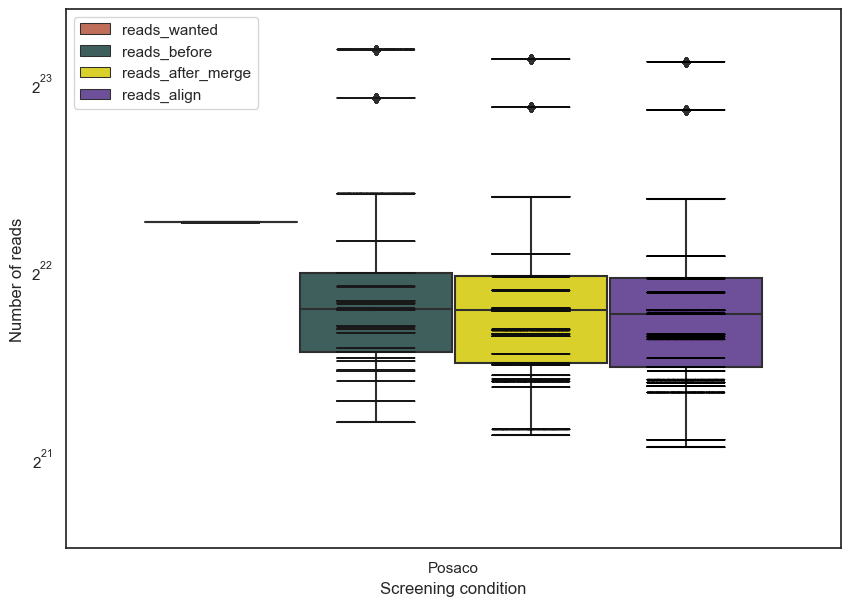

In [61]:
df_melt = pd.melt(df_sum, id_vars=['Antifungal'],value_vars=['reads_wanted', "reads_before",'reads_after_merge',"reads_align"], var_name='Reads control', value_name='Reads')

plt.figure(figsize=(10, 7))
custom_palette = sns.blend_palette(["#CF6448","#386461","#F6EA0E","#6C44A6"], n_colors=4)

ax = sns.boxplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",palette = custom_palette)
ax = sns.stripplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",color="black",dodge=True, jitter=0.2, size=1)

plt.ylim(1500000, 11000000)

plt.yscale('log', base=2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4])

plt.xlabel('Screening condition')
plt.ylabel('Number of reads')

plt.show()

In [62]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [63]:
# remove wt, they have a count of 0 as they are not variants

ite = 0

for i in df_sum.iterrows() :
    
    first_row = df_sum.loc[ite]
    
    position = first_row['position']
    codon_wt = wt_dict[position]
    
    if first_row['codon'] == codon_wt :

        df_sum = df_sum.drop(ite)
        
    ite = ite+1   
    
df_sum = df_sum.reset_index()
df_sum

index              Condition  position codon  Timepoint Antifungal  \
0          0  CaERG11_0_Posaco_F1_A        55   AAA          0     Posaco   
1          1  CaERG11_0_Posaco_F1_A        55   AAC          0     Posaco   
2          2  CaERG11_0_Posaco_F1_A        55   AAG          0     Posaco   
3          3  CaERG11_0_Posaco_F1_A        55   AAT          0     Posaco   
4          4  CaERG11_0_Posaco_F1_A        55   ACC          0     Posaco   
...      ...                    ...       ...   ...        ...        ...   
47947  48853  CaERG11_2_Posaco_F4_C       511   TGT          2     Posaco   
47948  48854  CaERG11_2_Posaco_F4_C       511   TTA          2     Posaco   
47949  48855  CaERG11_2_Posaco_F4_C       511   TTC          2     Posaco   
47950  48856  CaERG11_2_Posaco_F4_C       511   TTG          2     Posaco   
47951  48857  CaERG11_2_Posaco_F4_C       511   TTT          2     Posaco   

      Fragment Replicate         OD  nbr_reads  reads_wanted  reads_before  \
0           F1         A   0.000000      343.0       5000000       3945199   
1           F1         A   0.000000      269.0       5000000       3945199   
2           F1         A   0.000000      412.0       5000000       3945199   
3           F1         A   0.000000      229.0       5000000       3945199   
4           F1         A   0.000000      222.0       5000000       3945199   
...        ...       ...        ...        ...           ...           ...   
47947       F4         C  10.375562     1992.0       5000000       7922943   
47948       F4         C  10.375562      884.0       5000000       7922943   
47949       F4         C  10.375562     2566.0       5000000       7922943   
47950       F4         C  10.375562      959.0       5000000       7922943   
47951       F4         C  10.375562     2751.0       5000000       7922943   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                3888812            814933      3859362    262904  
1                3888812            814933      3859362    262904  
2                3888812            814933      3859362    262904  
3                3888812            814933      3859362    262904  
4                3888812            814933      3859362    262904  
...                  ...               ...          ...       ...  
47947            7655488           1776221      7580278    524469  
47948            7655488           1776221      7580278    524469  
47949            7655488           1776221      7580278    524469  
47950            7655488           1776221      7580278    524469  
47951            7655488           1776221      7580278    524469  

[47952 rows x 16 columns]

In [64]:
#Now we summed the lanes we can put more info in the df : reads in log and normalized. 
#You have to add +1 to the number of reads if you want to be able to get the log2

df_sum['nbr_reads_log'] = np.log2(df_sum['nbr_reads']+1)
df_sum['norm_reads'] = ((df_sum['nbr_reads']+1) / df_sum['reads_align'])
df_sum['norm_reads_log'] = np.log2(df_sum['norm_reads'])

df_sum=df_sum.reset_index()
df_sum = df_sum.drop("index",axis=1)

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date
df_sum.to_csv(f"c:{name}.csv")  

# 3- Selection coefficient

In [65]:
#open the variants counts with summed lanes

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
df_v = pd.read_csv(name, header=0, index_col = 0)
df_v

level_0              Condition  position codon  Timepoint Antifungal  \
0            0  CaERG11_0_Posaco_F1_A        55   AAA          0     Posaco   
1            1  CaERG11_0_Posaco_F1_A        55   AAC          0     Posaco   
2            2  CaERG11_0_Posaco_F1_A        55   AAG          0     Posaco   
3            3  CaERG11_0_Posaco_F1_A        55   AAT          0     Posaco   
4            4  CaERG11_0_Posaco_F1_A        55   ACC          0     Posaco   
...        ...                    ...       ...   ...        ...        ...   
47947    47947  CaERG11_2_Posaco_F4_C       511   TGT          2     Posaco   
47948    47948  CaERG11_2_Posaco_F4_C       511   TTA          2     Posaco   
47949    47949  CaERG11_2_Posaco_F4_C       511   TTC          2     Posaco   
47950    47950  CaERG11_2_Posaco_F4_C       511   TTG          2     Posaco   
47951    47951  CaERG11_2_Posaco_F4_C       511   TTT          2     Posaco   

      Fragment Replicate         OD  nbr_reads  reads_wanted  reads_before  \
0           F1         A   0.000000      343.0       5000000       3945199   
1           F1         A   0.000000      269.0       5000000       3945199   
2           F1         A   0.000000      412.0       5000000       3945199   
3           F1         A   0.000000      229.0       5000000       3945199   
4           F1         A   0.000000      222.0       5000000       3945199   
...        ...       ...        ...        ...           ...           ...   
47947       F4         C  10.375562     1992.0       5000000       7922943   
47948       F4         C  10.375562      884.0       5000000       7922943   
47949       F4         C  10.375562     2566.0       5000000       7922943   
47950       F4         C  10.375562      959.0       5000000       7922943   
47951       F4         C  10.375562     2751.0       5000000       7922943   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  \
0                3888812            814933      3859362    262904   
1                3888812            814933      3859362    262904   
2                3888812            814933      3859362    262904   
3                3888812            814933      3859362    262904   
4                3888812            814933      3859362    262904   
...                  ...               ...          ...       ...   
47947            7655488           1776221      7580278    524469   
47948            7655488           1776221      7580278    524469   
47949            7655488           1776221      7580278    524469   
47950            7655488           1776221      7580278    524469   
47951            7655488           1776221      7580278    524469   

       nbr_reads_log  norm_reads  norm_reads_log  
0           8.426265    0.000089      -13.453666  
1           8.076816    0.000070      -13.803115  
2           8.689998    0.000107      -13.189933  
3           7.845490    0.000060      -14.034441  
4           7.800900    0.000058      -14.079031  
...              ...         ...             ...  
47947      10.960726    0.000263      -11.893093  
47948       9.789534    0.000117      -13.064286  
47949      11.325868    0.000339      -11.527952  
47950       9.906891    0.000127      -12.946929  
47951      11.426265    0.000363      -11.427555  

[47952 rows x 19 columns]

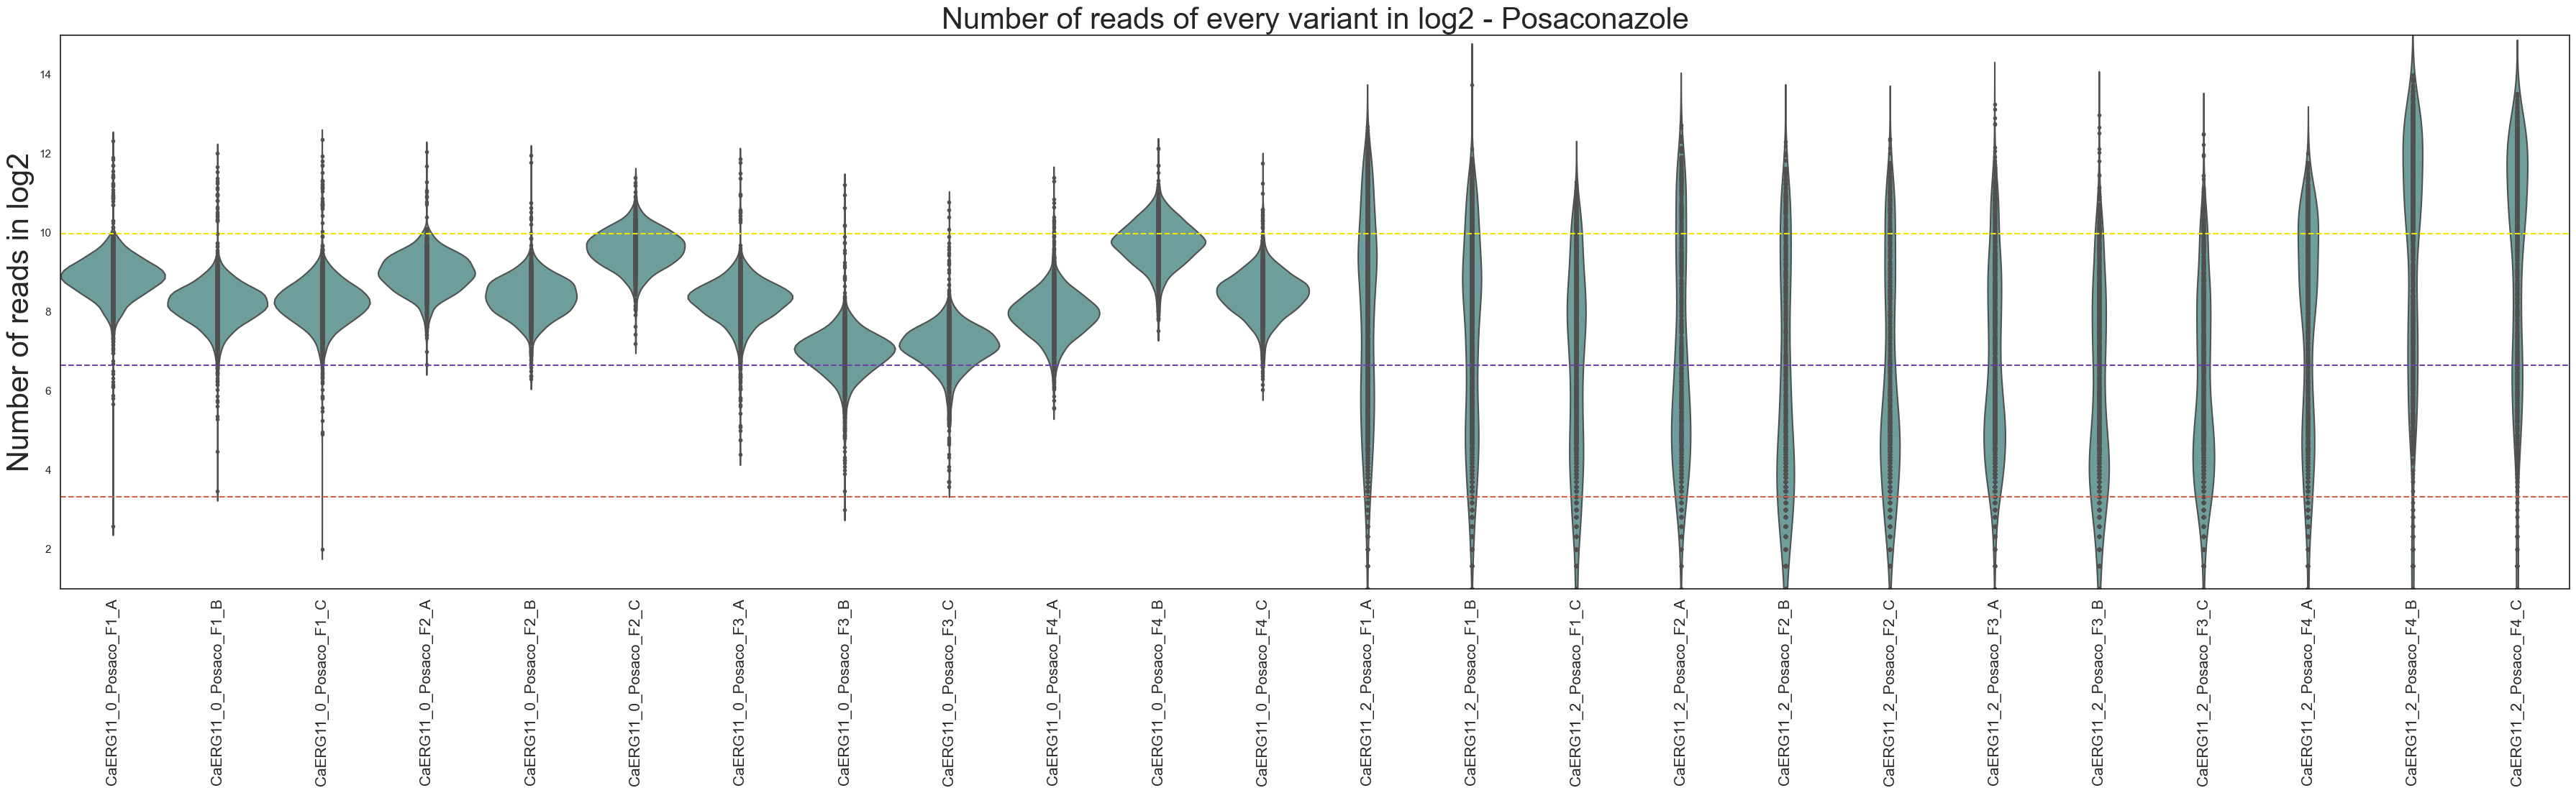

In [66]:

sns.set_style("white")

row = 0
sns.set_theme(style="white", palette=None)
plt.figure(figsize=(45,10))

sns.violinplot(data = df_v, x = 'Condition', y = 'nbr_reads_log',  inner = "point",width=1, color = "#65A6A2")
plt.ylabel("Number of reads in log2",fontsize = 30)
plt.xlabel("")
plt.tick_params(axis="x", labelsize=15, rotation = 90) 
title = condition
plt.title(title, fontsize = 40)
plt.axhline(9.97, color="#EEE304", linestyle="--")
plt.axhline(6.64, color = "#6C44A6", linestyle="--")
plt.axhline(3.32, color = "#D06448", linestyle="--")
plt.ylim(1, 15)


plt.title(f'Number of reads of every variant in log2 - {condition}',y=1, fontsize=30)

name = "./violin_plot_reads_all_log2_lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
plt.savefig(f'{name}.png', transparent=True, dpi=400, bbox_inches='tight')

In [67]:
#Get a wide format with reads at every timepoint

#reads norm not in log
df_wide_tp = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"], 
                            columns= "Timepoint", values="norm_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tp=df_wide_tp[colus]

df_wide_tp = df_wide_tp.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tp = df_wide_tp.rename(columns={0: 'freq_tp0', 1 : "freq_tp1",
                                        2 : "freq_tp2", 3 : "freq_tp3"}) #remove 3 if no tp3

df_wide_tp

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2
0                55   AAA     Posaco       F1         A  0.000089  0.000019
1                55   AAA     Posaco       F1         B  0.000042  0.000018
2                55   AAA     Posaco       F1         C  0.000069  0.000009
3                55   AAC     Posaco       F1         A  0.000070  0.000029
4                55   AAC     Posaco       F1         B  0.000028  0.000019
...             ...   ...        ...      ...       ...       ...       ...
23971           511   TTG     Posaco       F4         B  0.000208  0.000130
23972           511   TTG     Posaco       F4         C  0.000085  0.000127
23973           511   TTT     Posaco       F4         A  0.000048  0.000260
23974           511   TTT     Posaco       F4         B  0.000156  0.000344
23975           511   TTT     Posaco       F4         C  0.000066  0.000363

[23976 rows x 7 columns]

In [68]:
#df wide with raw nbr reads
df_wide_tpnbr = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="nbr_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tpnbr=df_wide_tpnbr[colus]

df_wide_tpnbr = df_wide_tpnbr.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpnbr = df_wide_tpnbr.rename(columns={0: 'nbr_tp0', 1 : "nbr_tp1",
                                              2 : "nbr_tp2", 3 : "nbr_tp3"}) #remove 3 if no tp3
df_wide_tpnbr

Timepoint  position codon Antifungal Fragment Replicate  nbr_tp0  nbr_tp2
0                55   AAA     Posaco       F1         A    343.0     82.0
1                55   AAA     Posaco       F1         B    230.0     65.0
2                55   AAA     Posaco       F1         C    279.0     33.0
3                55   AAC     Posaco       F1         A    269.0    125.0
4                55   AAC     Posaco       F1         B    151.0     69.0
...             ...   ...        ...      ...       ...      ...      ...
23971           511   TTG     Posaco       F4         B    739.0   1176.0
23972           511   TTG     Posaco       F4         C    279.0    959.0
23973           511   TTT     Posaco       F4         A    158.0    927.0
23974           511   TTT     Posaco       F4         B    556.0   3118.0
23975           511   TTT     Posaco       F4         C    214.0   2751.0

[23976 rows x 7 columns]

In [69]:
#df wide with OD
df_wide_tpod = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="OD")

colus = df_sum['Timepoint'].unique()
df_wide_tpod=df_wide_tpod[colus]

df_wide_tpod = df_wide_tpod.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpod = df_wide_tpod.rename(columns={0: 'OD_tp0', 1 : "OD_tp1",
                                              2 : "OD_tp2", 3 : "OD_tp3"}) #remove 3 if no tp3
df_wide_tpod

Timepoint  position codon Antifungal Fragment Replicate  OD_tp0     OD_tp2
0                55   AAA     Posaco       F1         A     0.0  10.248676
1                55   AAA     Posaco       F1         B     0.0  10.167699
2                55   AAA     Posaco       F1         C     0.0  10.350231
3                55   AAC     Posaco       F1         A     0.0  10.248676
4                55   AAC     Posaco       F1         B     0.0  10.167699
...             ...   ...        ...      ...       ...     ...        ...
23971           511   TTG     Posaco       F4         B     0.0  10.463001
23972           511   TTG     Posaco       F4         C     0.0  10.375562
23973           511   TTT     Posaco       F4         A     0.0  10.368533
23974           511   TTT     Posaco       F4         B     0.0  10.463001
23975           511   TTT     Posaco       F4         C     0.0  10.375562

[23976 rows x 7 columns]

In [70]:
#merge wide with frequencies,raw nbrs of reads and od
merged_df = pd.merge(df_wide_tp, df_wide_tpnbr, on=['position', 'codon', "Antifungal", "Fragment", "Replicate"])

merged_df = pd.merge(merged_df, df_wide_tpod, on=['position', 'codon', "Antifungal", "Fragment", 
                                                    "Replicate"])
merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA     Posaco       F1         A  0.000089  0.000019   
1                55   AAA     Posaco       F1         B  0.000042  0.000018   
2                55   AAA     Posaco       F1         C  0.000069  0.000009   
3                55   AAC     Posaco       F1         A  0.000070  0.000029   
4                55   AAC     Posaco       F1         B  0.000028  0.000019   
...             ...   ...        ...      ...       ...       ...       ...   
23971           511   TTG     Posaco       F4         B  0.000208  0.000130   
23972           511   TTG     Posaco       F4         C  0.000085  0.000127   
23973           511   TTT     Posaco       F4         A  0.000048  0.000260   
23974           511   TTT     Posaco       F4         B  0.000156  0.000344   
23975           511   TTT     Posaco       F4         C  0.000066  0.000363   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  
0            343.0     82.0     0.0  10.248676  
1            230.0     65.0     0.0  10.167699  
2            279.0     33.0     0.0  10.350231  
3            269.0    125.0     0.0  10.248676  
4            151.0     69.0     0.0  10.167699  
...            ...      ...     ...        ...  
23971        739.0   1176.0     0.0  10.463001  
23972        279.0    959.0     0.0  10.375562  
23973        158.0    927.0     0.0  10.368533  
23974        556.0   3118.0     0.0  10.463001  
23975        214.0   2751.0     0.0  10.375562  

[23976 rows x 11 columns]

In [71]:
#log2foldchange calculation

merged_df['log2(tp2/tp0)'] = np.log2((df_wide_tp["freq_tp2"] / df_wide_tp["freq_tp0"]))

 


merged_df = merged_df.rename(columns={'log2(tp2/tp0)': 'l2fc_0_2'})

merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA     Posaco       F1         A  0.000089  0.000019   
1                55   AAA     Posaco       F1         B  0.000042  0.000018   
2                55   AAA     Posaco       F1         C  0.000069  0.000009   
3                55   AAC     Posaco       F1         A  0.000070  0.000029   
4                55   AAC     Posaco       F1         B  0.000028  0.000019   
...             ...   ...        ...      ...       ...       ...       ...   
23971           511   TTG     Posaco       F4         B  0.000208  0.000130   
23972           511   TTG     Posaco       F4         C  0.000085  0.000127   
23973           511   TTT     Posaco       F4         A  0.000048  0.000260   
23974           511   TTT     Posaco       F4         B  0.000156  0.000344   
23975           511   TTT     Posaco       F4         C  0.000066  0.000363   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  
0            343.0     82.0     0.0  10.248676 -2.245079  
1            230.0     65.0     0.0  10.167699 -1.212214  
2            279.0     33.0     0.0  10.350231 -2.872143  
3            269.0    125.0     0.0  10.248676 -1.293389  
4            151.0     69.0     0.0  10.167699 -0.523503  
...            ...      ...     ...        ...       ...  
23971        739.0   1176.0     0.0  10.463001 -0.675489  
23972        279.0    959.0     0.0  10.375562  0.568457  
23973        158.0    927.0     0.0  10.368533  2.432904  
23974        556.0   3118.0     0.0  10.463001  1.140328  
23975        214.0   2751.0     0.0  10.375562  2.468921  

[23976 rows x 12 columns]

In [72]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in merged_df.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
merged_df["aa"] = aa_list
merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA     Posaco       F1         A  0.000089  0.000019   
1                55   AAA     Posaco       F1         B  0.000042  0.000018   
2                55   AAA     Posaco       F1         C  0.000069  0.000009   
3                55   AAC     Posaco       F1         A  0.000070  0.000029   
4                55   AAC     Posaco       F1         B  0.000028  0.000019   
...             ...   ...        ...      ...       ...       ...       ...   
23971           511   TTG     Posaco       F4         B  0.000208  0.000130   
23972           511   TTG     Posaco       F4         C  0.000085  0.000127   
23973           511   TTT     Posaco       F4         A  0.000048  0.000260   
23974           511   TTT     Posaco       F4         B  0.000156  0.000344   
23975           511   TTT     Posaco       F4         C  0.000066  0.000363   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2 aa  
0            343.0     82.0     0.0  10.248676 -2.245079  K  
1            230.0     65.0     0.0  10.167699 -1.212214  K  
2            279.0     33.0     0.0  10.350231 -2.872143  K  
3            269.0    125.0     0.0  10.248676 -1.293389  N  
4            151.0     69.0     0.0  10.167699 -0.523503  N  
...            ...      ...     ...        ...       ... ..  
23971        739.0   1176.0     0.0  10.463001 -0.675489  L  
23972        279.0    959.0     0.0  10.375562  0.568457  L  
23973        158.0    927.0     0.0  10.368533  2.432904  F  
23974        556.0   3118.0     0.0  10.463001  1.140328  F  
23975        214.0   2751.0     0.0  10.375562  2.468921  F  

[23976 rows x 13 columns]

In [73]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [74]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

In [75]:
# get all the wts infos in our df

df_wt = merged_df  # Assigning merged_df to df_wt

ite = 0  # Initializing a counter variable

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable
    
df_wt = df_wt.reset_index()
df_wt  # Outputting the filtered DataFrame

Timepoint  index  position codon Antifungal Fragment Replicate  freq_tp0  \
0             21        55   ATC     Posaco       F1         A  0.000062   
1             22        55   ATC     Posaco       F1         B  0.000034   
2             23        55   ATC     Posaco       F1         C  0.000056   
3             27        55   ATT     Posaco       F1         A  0.000108   
4             28        55   ATT     Posaco       F1         B  0.000051   
..           ...       ...   ...        ...      ...       ...       ...   
799        23965       511   TTA     Posaco       F4         B  0.000150   
800        23966       511   TTA     Posaco       F4         C  0.000078   
801        23970       511   TTG     Posaco       F4         A  0.000071   
802        23971       511   TTG     Posaco       F4         B  0.000208   
803        23972       511   TTG     Posaco       F4         C  0.000085   

Timepoint  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2 aa  
0          0.000107    237.0    470.0     0.0  10.248676  0.790912  I  
1          0.000068    183.0    243.0     0.0  10.167699  1.002317  I  
2          0.000045    228.0    162.0     0.0  10.350231 -0.320798  I  
3          0.000118    416.0    522.0     0.0  10.248676  0.132910  I  
4          0.000089    275.0    320.0     0.0  10.167699  0.813046  I  
..              ...      ...      ...     ...        ...       ... ..  
799        0.000090    534.0    818.0     0.0  10.463001 -0.730682  L  
800        0.000117    256.0    884.0     0.0  10.375562  0.574758  L  
801        0.000074    233.0    264.0     0.0  10.368533  0.067290  L  
802        0.000130    739.0   1176.0     0.0  10.463001 -0.675489  L  
803        0.000127    279.0    959.0     0.0  10.375562  0.568457  L  

[804 rows x 14 columns]

In [76]:
# get all the synonymous wts infos, they are the most representative of wt behaviour as they are in frequencies similar
# to other variants in comparison with wt that is in higher frequency and correspond only to one measure

df_wt_syn = df_wt

ite = 0

for i in df_wt_syn.iterrows() :
    
    first_row = df_wt_syn.loc[ite]
    
    position = first_row['position']
    aa_wt = aa_dict[position]
    codon_wt = wt_dict[position]
    print(first_row['codon'])
    
    if first_row['codon'] == codon_wt :

        df_wt_syn = df_wt_syn.drop(ite)
        print("remove : " + str(position) + codon_wt)
        
    ite = ite+1   
    
df_wt_syn = df_wt_syn.reset_index().drop("index",axis=1).drop("level_0",axis=1)
df_wt_syn

ATC
ATC
ATC
ATT
ATT
ATT
TTT
TTT
TTT
GGA
GGA
GGA
GGT
GGT
GGT
TCC
TCC
TCC
TCT
TCT
TCT
GCC
GCC
GCC
GCT
GCT
GCT
GCC
GCC
GCC
GCT
GCT
GCT
TCC
TCC
TCC
TAC
TAC
TAC
GGA
GGA
GGA
CAG
CAG
CAG
CAG
CAG
CAG
CCA
CCA
CCA
CCT
CCT
CCT
TAC
TAC
TAC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTA
TTA
TTA
TTG
TTG
TTG
TTA
TTA
TTA
TTG
TTG
TTG
GGA
GGA
GGA
GGT
GGT
GGT
AAG
AAG
AAG
GTC
GTC
GTC
GTT
GTT
GTT
GGA
GGA
GGA
CAT
CAT
CAT
GAG
GAG
GAG
TTC
TTC
TTC
GTT
GTT
GTT
TTT
TTT
TTT
AAC
AAC
AAC
GCC
GCC
GCC
GCT
GCT
GCT
TTG
TTG
TTG
GTT
GTT
GTT
TCC
TCC
TCC
GCC
GCC
GCC
GAG
GAG
GAG
GAC
GAC
GAC
GCC
GCC
GCC
GCT
GCT
GCT
TAT
TAT
TAT
AAG
AAG
AAG
CAT
CAT
CAT
TTG
TTG
TTG
ACC
ACC
ACC
ACT
ACT
ACT
ACC
ACC
ACC
CCA
CCA
CCA
CCT
CCT
CCT
GTC
GTC
GTC
GTT
GTT
GTT
TTT
TTT
TTT
GGT
GGT
GGT
AAA
AAA
AAA
GGT
GGT
GGT
GTC
GTC
GTC
ATT
ATT
ATT
TAT
TAT
TAT
GAC
GAC
GAC
TGC
TGC
TGC
CCA
CCA
CCA
CCT
CCT
CCT
AAT
AAT
AAT
TCC
TCC
TCC
TCT
TCT
TCT
AGA
AGA
AGA
TTA
TTA
TTA
TTG
TTG
TTG
GAA
GAA
GAA
CAA
CAA
CAA
AAG
AAG
AAG
AAA
AAA
AAA
TTC
TTC
TTC
GCC
GCC
GCC
AAG
AAG
AAG
TTT


Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   ATC     Posaco       F1         A  0.000062  0.000107   
1                55   ATC     Posaco       F1         B  0.000034  0.000068   
2                55   ATC     Posaco       F1         C  0.000056  0.000045   
3                55   ATT     Posaco       F1         A  0.000108  0.000118   
4                55   ATT     Posaco       F1         B  0.000051  0.000089   
..              ...   ...        ...      ...       ...       ...       ...   
799             511   TTA     Posaco       F4         B  0.000150  0.000090   
800             511   TTA     Posaco       F4         C  0.000078  0.000117   
801             511   TTG     Posaco       F4         A  0.000071  0.000074   
802             511   TTG     Posaco       F4         B  0.000208  0.000130   
803             511   TTG     Posaco       F4         C  0.000085  0.000127   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2 aa  
0            237.0    470.0     0.0  10.248676  0.790912  I  
1            183.0    243.0     0.0  10.167699  1.002317  I  
2            228.0    162.0     0.0  10.350231 -0.320798  I  
3            416.0    522.0     0.0  10.248676  0.132910  I  
4            275.0    320.0     0.0  10.167699  0.813046  I  
..             ...      ...     ...        ...       ... ..  
799          534.0    818.0     0.0  10.463001 -0.730682  L  
800          256.0    884.0     0.0  10.375562  0.574758  L  
801          233.0    264.0     0.0  10.368533  0.067290  L  
802          739.0   1176.0     0.0  10.463001 -0.675489  L  
803          279.0    959.0     0.0  10.375562  0.568457  L  

[804 rows x 13 columns]

In [77]:
#wt for every fragment and replicate

wt_frag = df_wt_syn.groupby("Fragment")
f1_wt = wt_frag.get_group("F1").reset_index()
f2_wt = wt_frag.get_group("F2").reset_index()
f3_wt = wt_frag.get_group("F3").reset_index()
f4_wt = wt_frag.get_group("F4").reset_index()

wt_frag1_r = f1_wt.groupby("Replicate")
f1_wtA = wt_frag1_r.get_group("A").reset_index()
f1_wtB = wt_frag1_r.get_group("B").reset_index()
f1_wtC = wt_frag1_r.get_group("C").reset_index()

wt_frag2_r = f2_wt.groupby("Replicate")
f2_wtA = wt_frag2_r.get_group("A").reset_index()
f2_wtB = wt_frag2_r.get_group("B").reset_index()
f2_wtC = wt_frag2_r.get_group("C").reset_index()

wt_frag3_r = f3_wt.groupby("Replicate")
f3_wtA = wt_frag3_r.get_group("A").reset_index()
f3_wtB = wt_frag3_r.get_group("B").reset_index()
f3_wtC = wt_frag3_r.get_group("C").reset_index()

wt_frag4_r = f4_wt.groupby("Replicate")
f4_wtA = wt_frag4_r.get_group("A").reset_index()
f4_wtB = wt_frag4_r.get_group("B").reset_index()
f4_wtC = wt_frag4_r.get_group("C").reset_index()

merged_df["select_coef"] = np.nan #add an empty column to add our selection coefficient
merged_df_frag = merged_df.groupby("Fragment")

m1 = merged_df_frag.get_group("F1")
m1r = m1.groupby("Replicate")
m1_A = m1r.get_group("A").reset_index()
m1_B = m1r.get_group("B").reset_index()
m1_C = m1r.get_group("C").reset_index()

m2 = merged_df_frag.get_group("F2")
m2r = m2.groupby("Replicate")
m2_A = m2r.get_group("A").reset_index()
m2_B = m2r.get_group("B").reset_index()
m2_C = m2r.get_group("C").reset_index()

m3 = merged_df_frag.get_group("F3")
m3r = m3.groupby("Replicate")
m3_A = m3r.get_group("A").reset_index()
m3_B = m3r.get_group("B").reset_index()
m3_C = m3r.get_group("C").reset_index()

m4 = merged_df_frag.get_group("F4")
m4r = m4.groupby("Replicate")
m4_A = m4r.get_group("A").reset_index()
m4_B = m4r.get_group("B").reset_index()
m4_C = m4r.get_group("C").reset_index()


In [78]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m1_" + str(r)
    df = globals()[name]
    wt_name = "f1_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df1 = pd.concat(df_list, axis=0)

concatenated_df1 

0.0001497373593125
0.0001325624233407
7.442481240243848e-05


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0      0        55   AAA     Posaco       F1         A   
1                1      3        55   AAC     Posaco       F1         A   
2                2      6        55   AAG     Posaco       F1         A   
3                3      9        55   AAT     Posaco       F1         A   
4                4     12        55   ACC     Posaco       F1         A   
...            ...    ...       ...   ...        ...      ...       ...   
2832          2832   8930       162   TGT     Posaco       F1         C   
2833          2833   8936       162   TTA     Posaco       F1         C   
2834          2834   8942       162   TTC     Posaco       F1         C   
2835          2835   8948       162   TTG     Posaco       F1         C   
2836          2836   8954       162   TTT     Posaco       F1         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  \
0          0.000089  0.000019    343.0     82.0     0.0  10.248676 -2.245079   
1          0.000070  0.000029    269.0    125.0     0.0  10.248676 -1.293389   
2          0.000107  0.000026    412.0    114.0     0.0  10.248676 -2.038362   
3          0.000060  0.000022    229.0     96.0     0.0  10.248676 -1.439431   
4          0.000058  0.000036    222.0    160.0     0.0  10.248676 -0.663837   
...             ...       ...      ...      ...     ...        ...       ...   
2832       0.000041  0.000034    164.0    122.0     0.0  10.350231 -0.254130   
2833       0.000078  0.000016    316.0     56.0     0.0  10.350231 -2.305772   
2834       0.000074  0.000014    298.0     51.0     0.0  10.350231 -2.353885   
2835       0.000066  0.000024    267.0     87.0     0.0  10.350231 -1.436980   
2836       0.000075  0.000015    302.0     53.0     0.0  10.350231 -2.318609   

Timepoint aa  select_coef    nbr_gen  
0          K    -0.235416  10.248676  
1          N    -0.142556  10.248676  
2          K    -0.215246  10.248676  
3          N    -0.156806  10.248676  
4          T    -0.081129  10.248676  
...       ..          ...        ...  
2832       C    -0.013093  10.350231  
2833       L    -0.211315  10.350231  
2834       F    -0.215964  10.350231  
2835       L    -0.127376  10.350231  
2836       F    -0.212556  10.350231  

[8511 rows x 17 columns]

In [79]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m2_" + str(r)
    df = globals()[name]
    wt_name = "f2_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df2 = pd.concat(df_list, axis=0)

concatenated_df2 

0.0001862310644913
0.0001392138496477
0.00013874944815555002


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0   8067       154   AAA     Posaco       F2         A   
1                1   8073       154   AAC     Posaco       F2         A   
2                2   8079       154   AAG     Posaco       F2         A   
3                3   8085       154   AAT     Posaco       F2         A   
4                4   8091       154   ACC     Posaco       F2         A   
...            ...    ...       ...   ...        ...      ...       ...   
1151          1151  12287       280   TGT     Posaco       F2         C   
1152          1152  12293       280   TTA     Posaco       F2         C   
1153          1153  12299       280   TTC     Posaco       F2         C   
1154          1154  12305       280   TTG     Posaco       F2         C   
1155          1155  12311       280   TTT     Posaco       F2         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000132  0.000671    380.0   2218.0     0.0  9.833252  2.346761   
1          0.000142  0.000037    410.0    121.0     0.0  9.833252 -1.947543   
2          0.000166  0.000782    477.0   2584.0     0.0  9.833252  2.239796   
3          0.000108  0.000024    310.0     78.0     0.0  9.833252 -2.172275   
4          0.000151  0.000035    436.0    115.0     0.0  9.833252 -2.108794   
...             ...       ...      ...      ...     ...       ...       ...   
1151       0.000290  0.000008    810.0     22.0     0.0  9.872039 -5.208734   
1152       0.000152  0.000084    423.0    244.0     0.0  9.872039 -0.860020   
1153       0.000188  0.000015    526.0     44.0     0.0  9.872039 -3.618544   
1154       0.000181  0.000117    506.0    343.0     0.0  9.872039 -0.628315   
1155       0.000167  0.000018    466.0     53.0     0.0  9.872039 -3.181129   

Timepoint aa  select_coef   nbr_gen  
0          K     0.237813  9.833252  
1          N    -0.198899  9.833252  
2          K     0.226935  9.833252  
3          N    -0.221754  9.833252  
4          T    -0.215298  9.833252  
...       ..          ...       ...  
1151       C    -0.430072  9.872039  
1152       L     0.010436  9.872039  
1153       F    -0.268992  9.872039  
1154       L     0.033907  9.872039  
1155       F    -0.224683  9.872039  

[3468 rows x 17 columns]

In [80]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m3_" + str(r)
    df = globals()[name]
    wt_name = "f3_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df3 = pd.concat(df_list, axis=0)

concatenated_df3 

0.00014067858642115
9.904586331794091e-05
0.0001183819090754


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0  11646       276   AAA     Posaco       F3         A   
1                1  11652       276   AAC     Posaco       F3         A   
2                2  11658       276   AAG     Posaco       F3         A   
3                3  11664       276   AAT     Posaco       F3         A   
4                4  11670       276   ACC     Posaco       F3         A   
...            ...    ...       ...   ...        ...      ...       ...   
2014          2014  18680       406   TGT     Posaco       F3         C   
2015          2015  18686       406   TTA     Posaco       F3         C   
2016          2016  18692       406   TTC     Posaco       F3         C   
2017          2017  18698       406   TTG     Posaco       F3         C   
2018          2018  18704       406   TTT     Posaco       F3         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  \
0          0.000119  0.000578    325.0   2061.0     0.0  10.099598  2.274404   
1          0.000088  0.000355    238.0   1266.0     0.0  10.099598  2.019638   
2          0.000104  0.000568    282.0   2026.0     0.0  10.099598  2.453776   
3          0.000137  0.000653    374.0   2328.0     0.0  10.099598  2.248052   
4          0.000117  0.000366    317.0   1305.0     0.0  10.099598  1.651360   
...             ...       ...      ...      ...     ...        ...       ...   
2014       0.000047  0.000065    101.0    179.0     0.0   9.855255  0.474771   
2015       0.000084  0.000176    182.0    487.0     0.0   9.855255  1.070381   
2016       0.000040  0.000118     87.0    325.0     0.0   9.855255  1.544640   
2017       0.000089  0.000157    193.0    434.0     0.0   9.855255  0.820302   
2018       0.000079  0.000155    171.0    427.0     0.0   9.855255  0.970545   

Timepoint aa  select_coef    nbr_gen  
0          K     0.205709  10.099598  
1          N     0.180483  10.099598  
2          K     0.223469  10.099598  
3          N     0.203099  10.099598  
4          T     0.144019  10.099598  
...       ..          ...        ...  
2014       C    -0.018099   9.855255  
2015       L     0.042337   9.855255  
2016       F     0.090459   9.855255  
2017       L     0.016961   9.855255  
2018       F     0.032206   9.855255  

[6057 rows x 17 columns]

In [81]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m4_" + str(r)
    df = globals()[name]
    wt_name = "f4_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"] 
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df4 = pd.concat(df_list, axis=0)

concatenated_df4 

0.00010233242330736617
0.00017079626721275
0.00018172156746755


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0  17367       401   AAA     Posaco       F4         A   
1                1  17373       401   AAC     Posaco       F4         A   
2                2  17379       401   AAG     Posaco       F4         A   
3                3  17385       401   AAT     Posaco       F4         A   
4                4  17391       401   ACC     Posaco       F4         A   
...            ...    ...       ...   ...        ...      ...       ...   
1975          1975  23963       511   TGT     Posaco       F4         C   
1976          1976  23966       511   TTA     Posaco       F4         C   
1977          1977  23969       511   TTC     Posaco       F4         C   
1978          1978  23972       511   TTG     Posaco       F4         C   
1979          1979  23975       511   TTT     Posaco       F4         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  \
0          0.000061  0.000002    201.0      7.0     0.0  10.368533 -4.770405   
1          0.000133  0.000021    437.0     74.0     0.0  10.368533 -2.658162   
2          0.000090  0.000006    297.0     19.0     0.0  10.368533 -4.009434   
3          0.000066  0.000006    217.0     19.0     0.0  10.368533 -3.558450   
4          0.000081  0.000008    266.0     29.0     0.0  10.368533 -3.265999   
...             ...       ...      ...      ...     ...        ...       ...   
1975       0.000111  0.000263    363.0   1992.0     0.0  10.375562  1.243780   
1976       0.000078  0.000117    256.0    884.0     0.0  10.375562  0.574758   
1977       0.000059  0.000339    191.0   2566.0     0.0  10.375562  2.531754   
1978       0.000085  0.000127    279.0    959.0     0.0  10.375562  0.568457   
1979       0.000066  0.000363    214.0   2751.0     0.0  10.375562  2.468921   

Timepoint aa  select_coef    nbr_gen  
0          K    -0.489610  10.368533  
1          N    -0.285894  10.368533  
2          K    -0.416218  10.368533  
3          N    -0.372723  10.368533  
4          T    -0.344517  10.368533  
...       ..          ...        ...  
1975       C     0.064300  10.375562  
1976       L    -0.000181  10.375562  
1977       F     0.188435  10.375562  
1978       L    -0.000788  10.375562  
1979       F     0.182379  10.375562  

[5940 rows x 17 columns]

In [82]:
###### save the df
F1_2_long = pd.concat([concatenated_df1 ,concatenated_df2 ],axis=0)
F3_4_long = pd.concat([concatenated_df3 , concatenated_df4 ],axis=0)
All_concat = pd.concat([F1_2_long, F3_4_long],axis=0)
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date
All_concat.to_csv(f"c:{name}.csv")  

All_concat

Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0      0        55   AAA     Posaco       F1         A   
1                1      3        55   AAC     Posaco       F1         A   
2                2      6        55   AAG     Posaco       F1         A   
3                3      9        55   AAT     Posaco       F1         A   
4                4     12        55   ACC     Posaco       F1         A   
...            ...    ...       ...   ...        ...      ...       ...   
1975          1975  23963       511   TGT     Posaco       F4         C   
1976          1976  23966       511   TTA     Posaco       F4         C   
1977          1977  23969       511   TTC     Posaco       F4         C   
1978          1978  23972       511   TTG     Posaco       F4         C   
1979          1979  23975       511   TTT     Posaco       F4         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  \
0          0.000089  0.000019    343.0     82.0     0.0  10.248676 -2.245079   
1          0.000070  0.000029    269.0    125.0     0.0  10.248676 -1.293389   
2          0.000107  0.000026    412.0    114.0     0.0  10.248676 -2.038362   
3          0.000060  0.000022    229.0     96.0     0.0  10.248676 -1.439431   
4          0.000058  0.000036    222.0    160.0     0.0  10.248676 -0.663837   
...             ...       ...      ...      ...     ...        ...       ...   
1975       0.000111  0.000263    363.0   1992.0     0.0  10.375562  1.243780   
1976       0.000078  0.000117    256.0    884.0     0.0  10.375562  0.574758   
1977       0.000059  0.000339    191.0   2566.0     0.0  10.375562  2.531754   
1978       0.000085  0.000127    279.0    959.0     0.0  10.375562  0.568457   
1979       0.000066  0.000363    214.0   2751.0     0.0  10.375562  2.468921   

Timepoint aa  select_coef    nbr_gen  
0          K    -0.235416  10.248676  
1          N    -0.142556  10.248676  
2          K    -0.215246  10.248676  
3          N    -0.156806  10.248676  
4          T    -0.081129  10.248676  
...       ..          ...        ...  
1975       C     0.064300  10.375562  
1976       L    -0.000181  10.375562  
1977       F     0.188435  10.375562  
1978       L    -0.000788  10.375562  
1979       F     0.182379  10.375562  

[23976 rows x 17 columns]

# 4- Control between replicates

In [83]:
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date + ".csv"
df_r = pd.read_csv(name, header=0, index_col = 0)
df_r = df_r.drop("level_0",axis=1).drop("index",axis=1)

<Axes:xlabel='Replicate', ylabel='Replicate'>

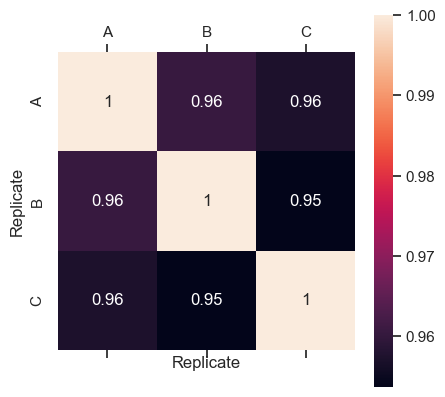

In [84]:
#Correlation condition 1

df_corr = pd.pivot_table(df_r, index=["position","codon","Fragment"], columns= "Replicate", values="select_coef")

colus2 = df_r['Replicate'].unique()
df_corr=df_corr[colus2]

plt.matshow(df_corr.corr())
corr_mat = df_corr.corr()
sns.heatmap(corr_mat, annot=True)

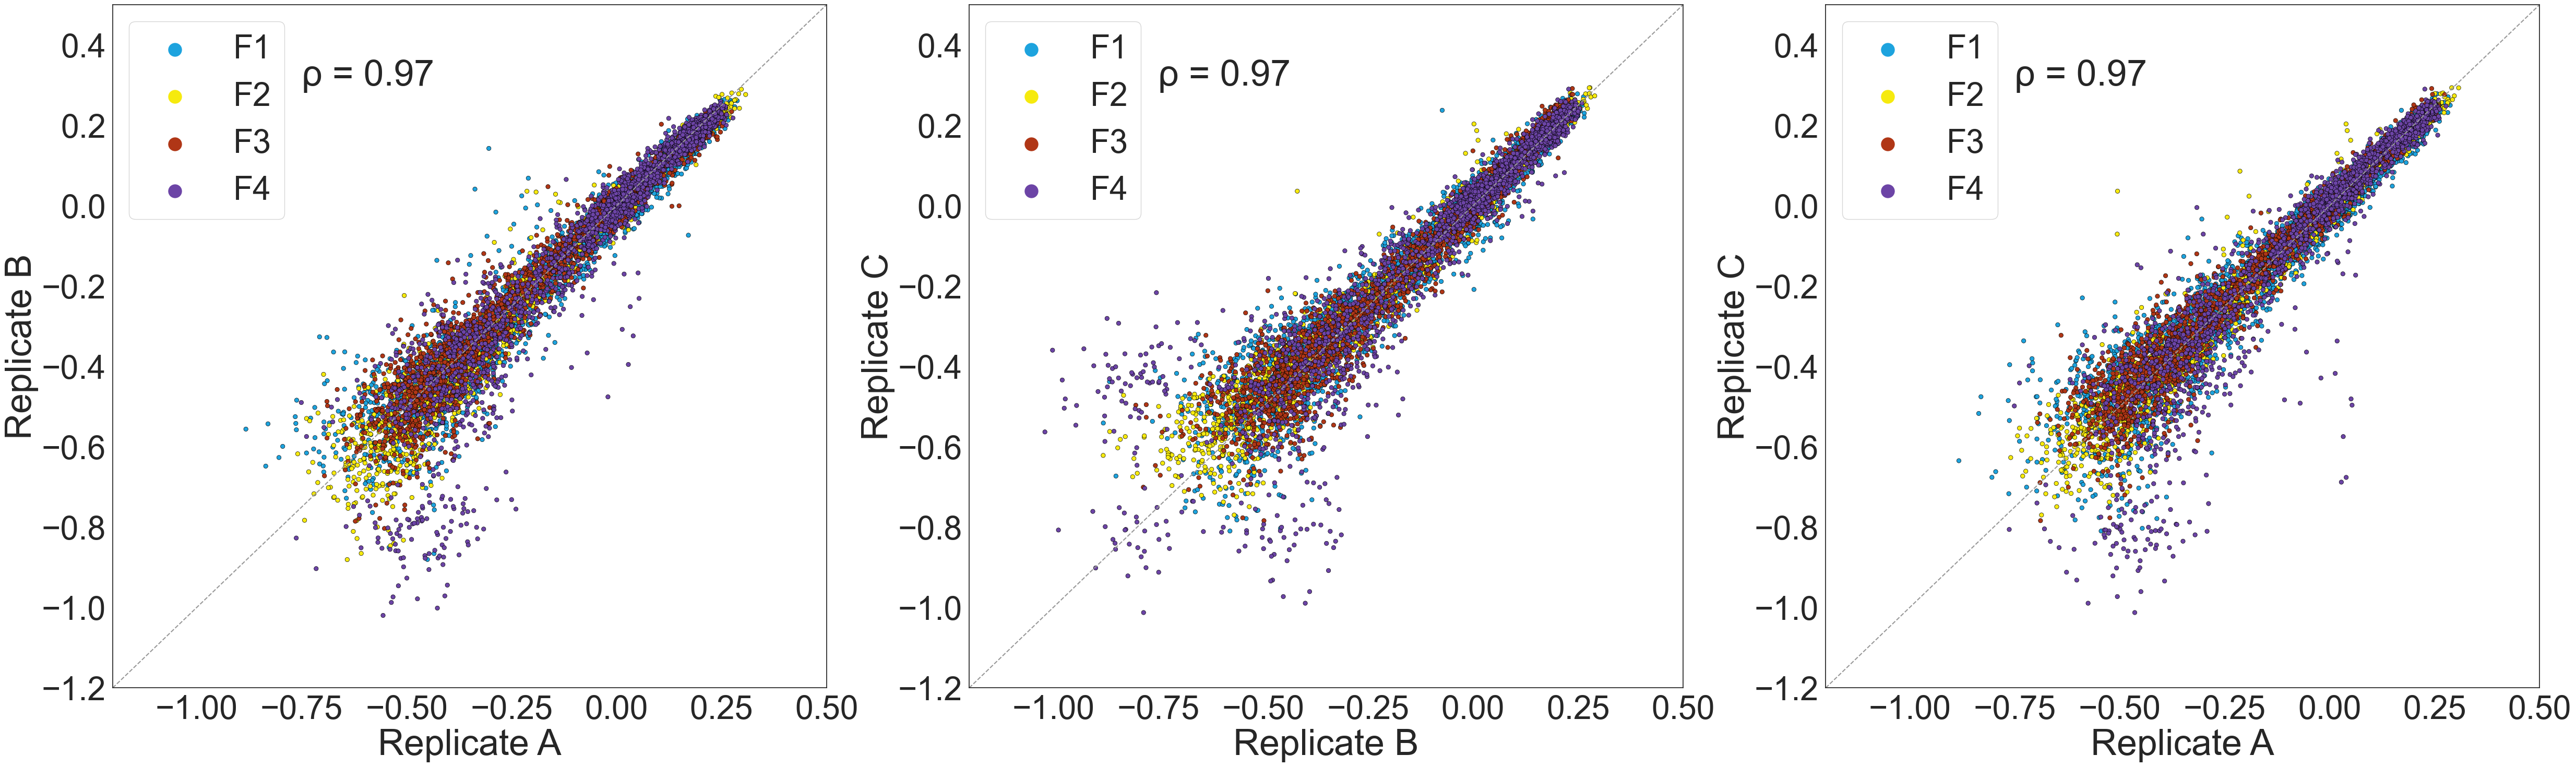

In [85]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")


r_list = ["A","B","A"]


r2_list = ["B","C","C"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(3) :
    
    sns.set_theme(style="white")
    
    colors = ["#1DA3DE","#F6EA0E","#B03616","#6C44A6"]
    custom_palette = sns.set_palette(sns.color_palette(colors))
    
    rep1 = df_r_g.get_group(r_list[i]).reset_index()
    rep2 = df_r_g.get_group(r2_list[i]).reset_index()
    

    
    sns.scatterplot(x=rep1["select_coef"],  y=rep2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = rep1["Fragment"],ax = axes[row])
    
    axes[row].set_ylabel("Replicate " + str(r2_list[i]), fontsize=50)
    axes[row].set_xlabel("Replicate " + str(r_list[i]), fontsize=50)
    
    #title = "Replicate " + str(r_list[i]) + " and Replicate " + str(r2_list[i])
    #axes[row].set_title(title, fontsize=55)
    
    axes[row].set_ylim(-1.2, 0.5)
    axes[row].set_xlim(-1.2, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-1.2, 0.5])
    y_vals = x_vals

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
    
    result = sp.stats.spearmanr(rep1["select_coef"],rep2["select_coef"])
    coeff = result[0]
    p_value = "{:.1e}".format(result[1])
    R2 = coeff**2     
    
    text = "ρ = " + str(round(coeff,2))
    #+ "\np-value = "  + str(p_value)
    axes[row].text(-0.75,0.3, text , fontsize = 50)
        
    row +=1
    
fig.subplots_adjust(hspace=0.31)
#fig.suptitle('Correlation between the Selection coefficient of replicates - ' + condition, y=0.95, fontsize=50)


plt.rcParams['svg.fonttype'] = 'none'
name = "Regression_replicate_select_coeff_" + condition + "_" + experiment + "_" + date
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [86]:
#Get the median of the replicates

df_group = df_r.groupby(["position","codon","Antifungal","Fragment","aa"])
cols = ["freq_tp0","freq_tp2","l2fc_0_2","nbr_tp0","nbr_tp2","nbr_gen","select_coef"]
df_med = df_group[cols].median()

#reset index so the index becomes columns again
df_med = df_med.reset_index(level=["position","codon","Antifungal","Fragment","aa"])

name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_med.to_csv(name)  
df_med

position codon Antifungal Fragment aa  freq_tp0  freq_tp2  l2fc_0_2  \
0           55   AAA     Posaco       F1  K  0.000069  0.000018 -2.245079   
1           55   AAC     Posaco       F1  N  0.000040  0.000019 -1.293389   
2           55   AAG     Posaco       F1  K  0.000072  0.000014 -2.038362   
3           55   AAT     Posaco       F1  N  0.000040  0.000013 -1.439431   
4           55   ACC     Posaco       F1  T  0.000028  0.000036 -0.370891   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT     Posaco       F4  C  0.000111  0.000263  0.905365   
7988       511   TTA     Posaco       F4  L  0.000078  0.000090  0.265611   
7989       511   TTC     Posaco       F4  F  0.000059  0.000290  1.782760   
7990       511   TTG     Posaco       F4  L  0.000085  0.000127  0.067290   
7991       511   TTT     Posaco       F4  F  0.000066  0.000344  2.432904   

      nbr_tp0  nbr_tp2    nbr_gen  select_coef  
0       279.0     65.0  10.248676    -0.237676  
1       161.0     69.0  10.248676    -0.169941  
2       293.0     51.0  10.248676    -0.283850  
3       162.0     46.0  10.248676    -0.217685  
4       135.0    160.0  10.248676    -0.031638  
...       ...      ...        ...          ...  
7987    363.0   1992.0  10.375562     0.064300  
7988    256.0    818.0  10.375562    -0.003909  
7989    191.0   2566.0  10.375562     0.142414  
7990    279.0    959.0  10.375562    -0.009784  
7991    214.0   2751.0  10.375562     0.182379  

[7992 rows x 12 columns]

# 5- Control between codons

In [87]:
name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_c = pd.read_csv(name, header=0, index_col = 0)
df_c

position codon Antifungal Fragment aa  freq_tp0  freq_tp2  l2fc_0_2  \
0           55   AAA     Posaco       F1  K  0.000069  0.000018 -2.245079   
1           55   AAC     Posaco       F1  N  0.000040  0.000019 -1.293389   
2           55   AAG     Posaco       F1  K  0.000072  0.000014 -2.038362   
3           55   AAT     Posaco       F1  N  0.000040  0.000013 -1.439431   
4           55   ACC     Posaco       F1  T  0.000028  0.000036 -0.370891   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT     Posaco       F4  C  0.000111  0.000263  0.905365   
7988       511   TTA     Posaco       F4  L  0.000078  0.000090  0.265611   
7989       511   TTC     Posaco       F4  F  0.000059  0.000290  1.782760   
7990       511   TTG     Posaco       F4  L  0.000085  0.000127  0.067290   
7991       511   TTT     Posaco       F4  F  0.000066  0.000344  2.432904   

      nbr_tp0  nbr_tp2    nbr_gen  select_coef  
0       279.0     65.0  10.248676    -0.237676  
1       161.0     69.0  10.248676    -0.169941  
2       293.0     51.0  10.248676    -0.283850  
3       162.0     46.0  10.248676    -0.217685  
4       135.0    160.0  10.248676    -0.031638  
...       ...      ...        ...          ...  
7987    363.0   1992.0  10.375562     0.064300  
7988    256.0    818.0  10.375562    -0.003909  
7989    191.0   2566.0  10.375562     0.142414  
7990    279.0    959.0  10.375562    -0.009784  
7991    214.0   2751.0  10.375562     0.182379  

[7992 rows x 12 columns]

In [88]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in df_c.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
df_c["aa"] = aa_list

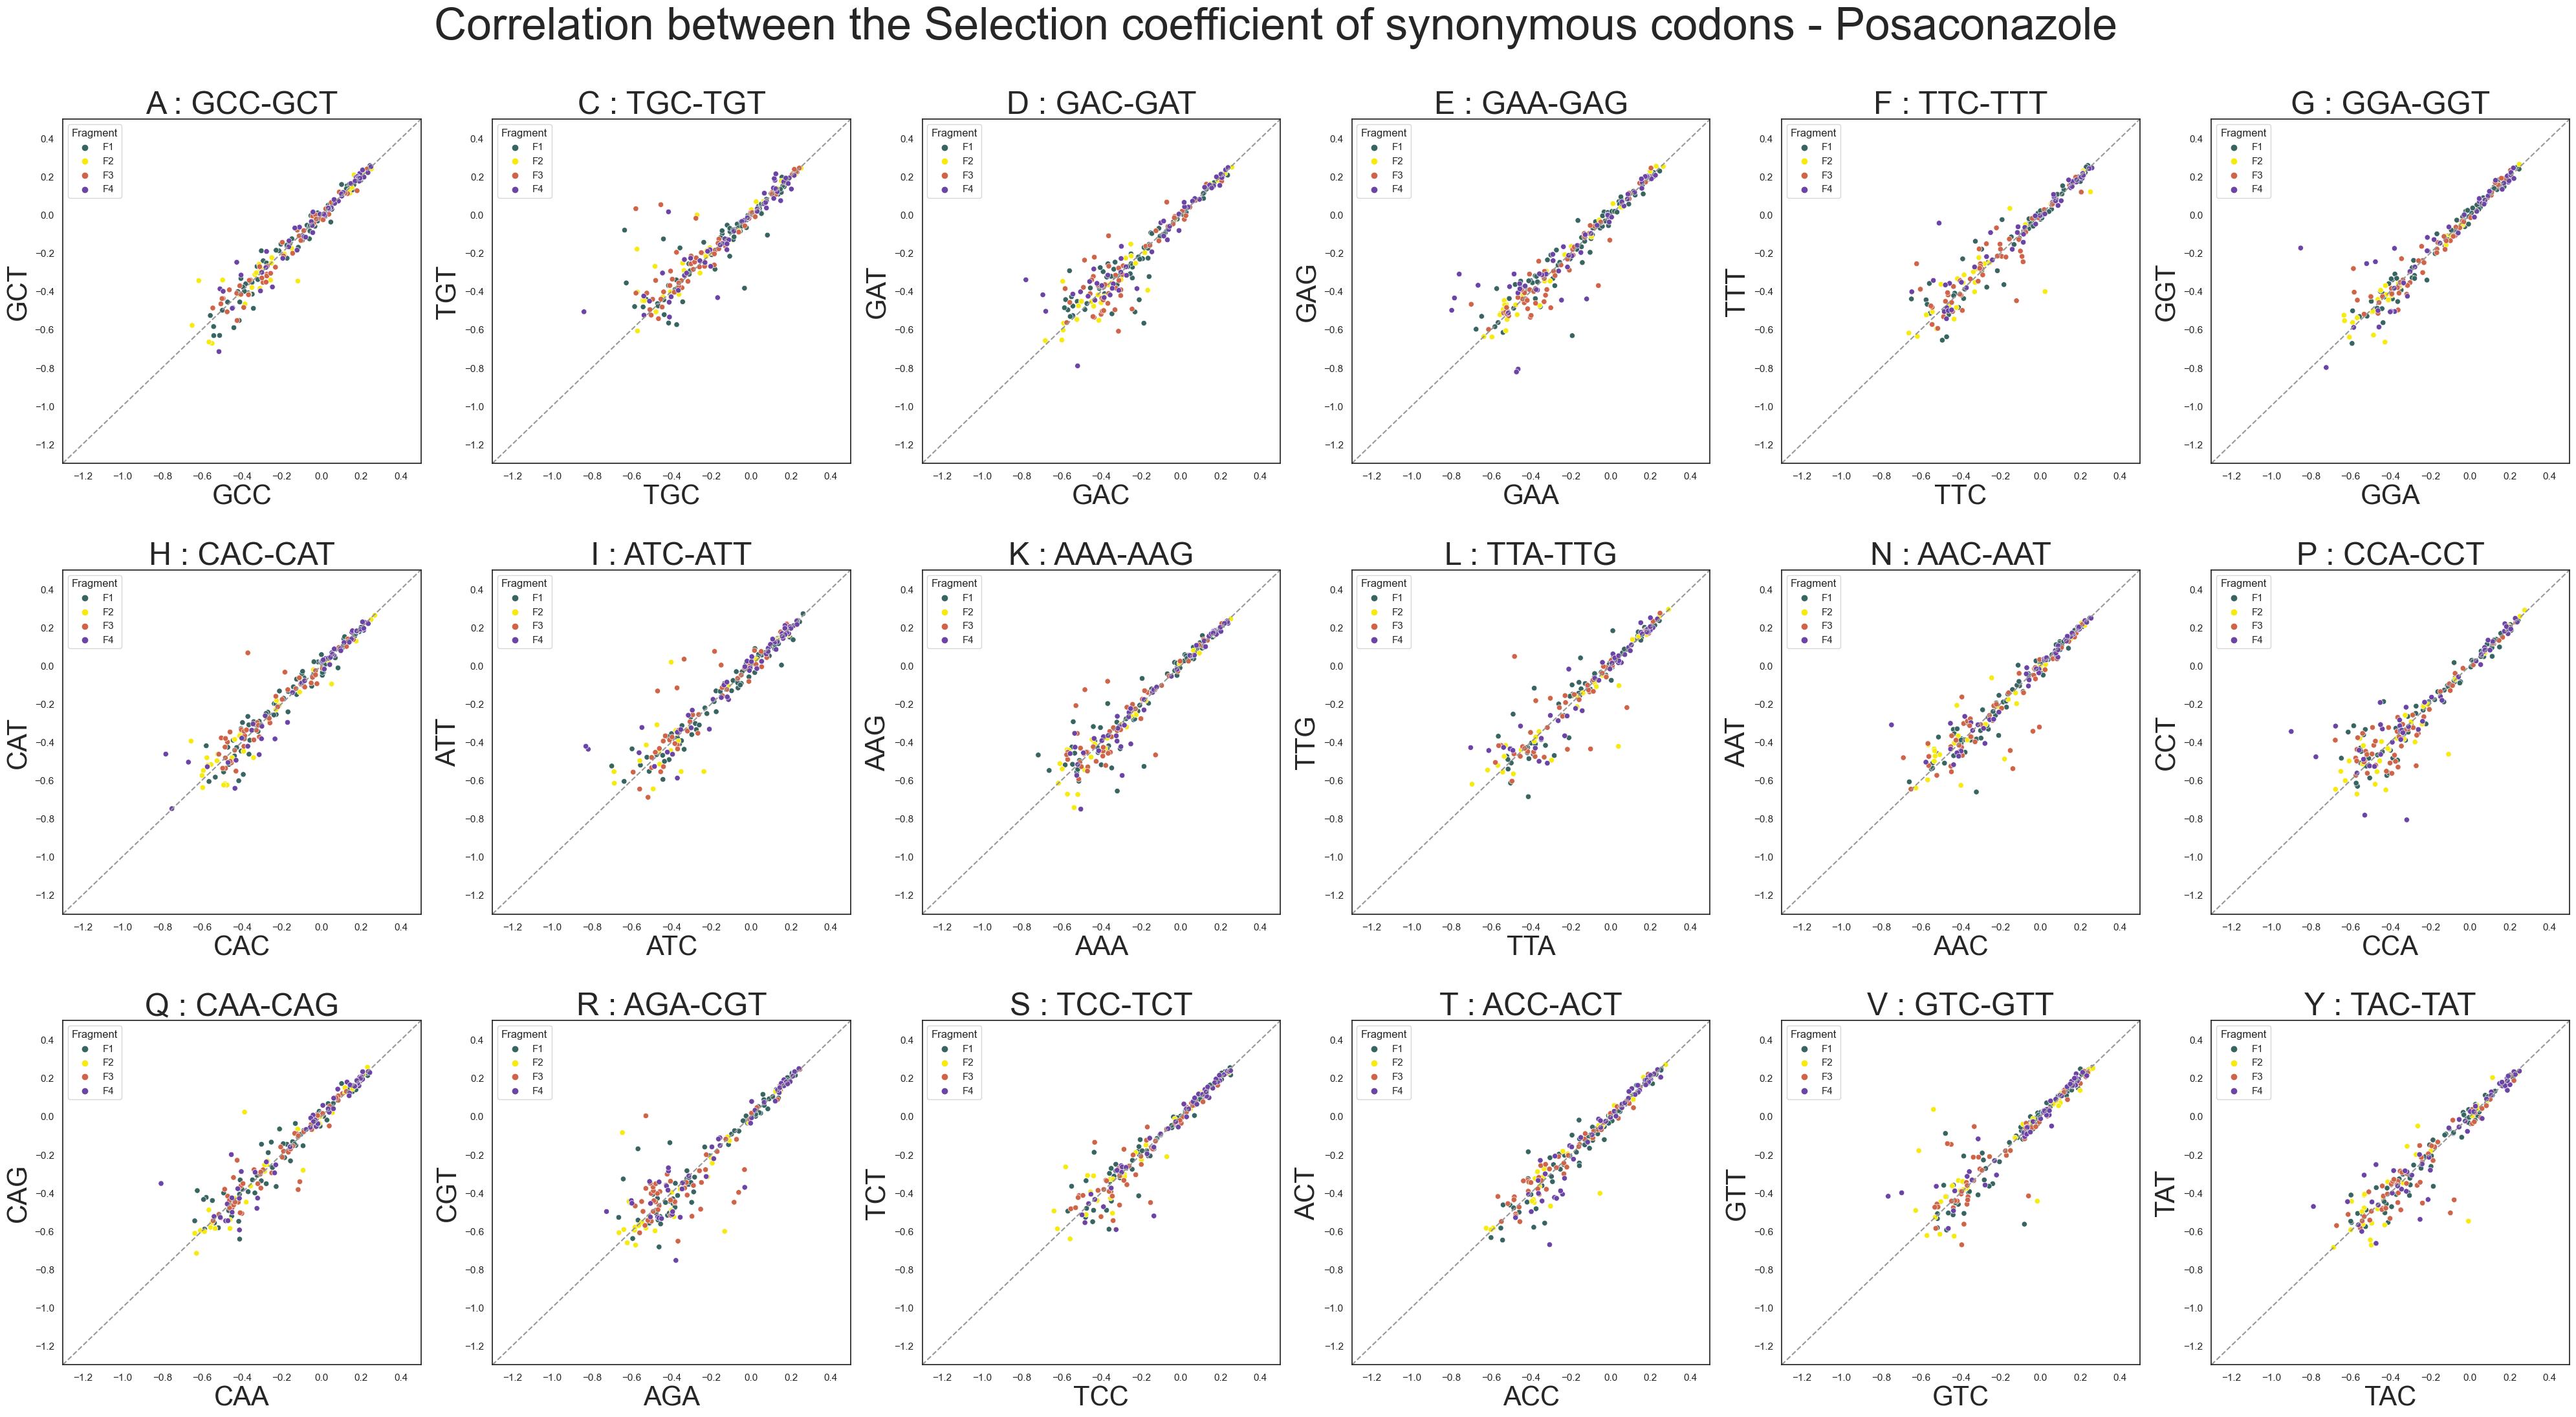

In [89]:
df_co = df_c

# remove wt as they often have only one codon

ite = 0  # Initializing a counter variable

for i in df_co.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_co.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] == aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_co = df_co.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable

df_cod = df_co.groupby(["codon"])
df_aa = df_co.groupby(["aa"])

syn_list = ["A","C","D","E","F","G","H","I","K","L","N","P","Q","R","S","T","V",'Y']

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(3, 6, figsize=(50,25))
axes = axes.flatten()
    
for aa in syn_list :
    
    sns.set_theme(style="white")
    
    colors = ["#386461","#F6EA0E","#CF6448","#6C44A6"]
    sns.set_palette(sns.color_palette(colors))
    
    amac = df_aa.get_group(aa)
    
    codons = amac['codon'].unique()
    
    cod1 = codons[0]
    cod2 = codons[1]

    cod_df = amac.groupby("codon")
    
    codon1 = cod_df.get_group(cod1).reset_index()
    codon2 = cod_df.get_group(cod2).reset_index()
    
    sns.scatterplot(x = codon1["select_coef"], y = codon2["select_coef"], legend = True, hue = codon1["Fragment"],ax = axes[row])
    axes[row].set_ylabel(cod2, fontsize=30)
    axes[row].set_xlabel(cod1, fontsize=30)
    title = aa + " : " + cod1 + "-" + cod2
    axes[row].set_title(title, fontsize=35)
    axes[row].set_ylim(-1.3, 0.5)
    axes[row].set_xlim(-1.3, 0.5)
    
    x_vals = np.array([-1.3, 0.5])
    y_vals = x_vals

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")

    row +=1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Correlation between the Selection coefficient of synonymous codons - ' + condition, y=0.95, fontsize=50)

name = "Correlation_between_synonymous_codons_" + "select_coeff_" + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

In [90]:
# get the mean of every codon

df_group = df_c.groupby(["position","aa","Antifungal","Fragment"])
cols = ["freq_tp0","freq_tp2","l2fc_0_2","nbr_tp0","nbr_tp2","select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal","Fragment"])

name = "Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name)  

# 6- Control between overlaps

#### We want to verify if the correlation between our overlap is good to see if our results are reproducible and constant.

In [91]:
name = "Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_o = pd.read_csv(name, header=0, index_col = 0)

In [92]:
df_o

position aa Antifungal Fragment  freq_tp0  freq_tp2  l2fc_0_2  nbr_tp0  \
0           55  *     Posaco       F1  0.000056  0.000003 -4.408867    244.0   
1           55  A     Posaco       F1  0.000045  0.000056  0.005073    209.5   
2           55  C     Posaco       F1  0.000059  0.000063 -0.139024    275.5   
3           55  D     Posaco       F1  0.000054  0.000007 -3.013095    237.5   
4           55  E     Posaco       F1  0.000071  0.000009 -3.163643    307.5   
...        ... ..        ...      ...       ...       ...       ...      ...   
4277       511  S     Posaco       F4  0.000069  0.000273  1.454156    225.5   
4278       511  T     Posaco       F4  0.000082  0.000052 -0.466783    268.5   
4279       511  V     Posaco       F4  0.000057  0.000046 -0.405436    185.5   
4280       511  W     Posaco       F4  0.000099  0.000026 -1.879216    322.0   
4281       511  Y     Posaco       F4  0.000083  0.000010 -3.123335    271.0   

      nbr_tp2  select_coef  
0        11.0    -0.456467  
1       200.0    -0.025771  
2       226.0    -0.059051  
3        23.5    -0.349018  
4        31.0    -0.372782  
...       ...          ...  
4277   2118.0     0.127347  
4278    385.0    -0.095493  
4279    352.5    -0.066424  
4280    234.0    -0.210768  
4281     76.0    -0.334133  

[4282 rows x 10 columns]

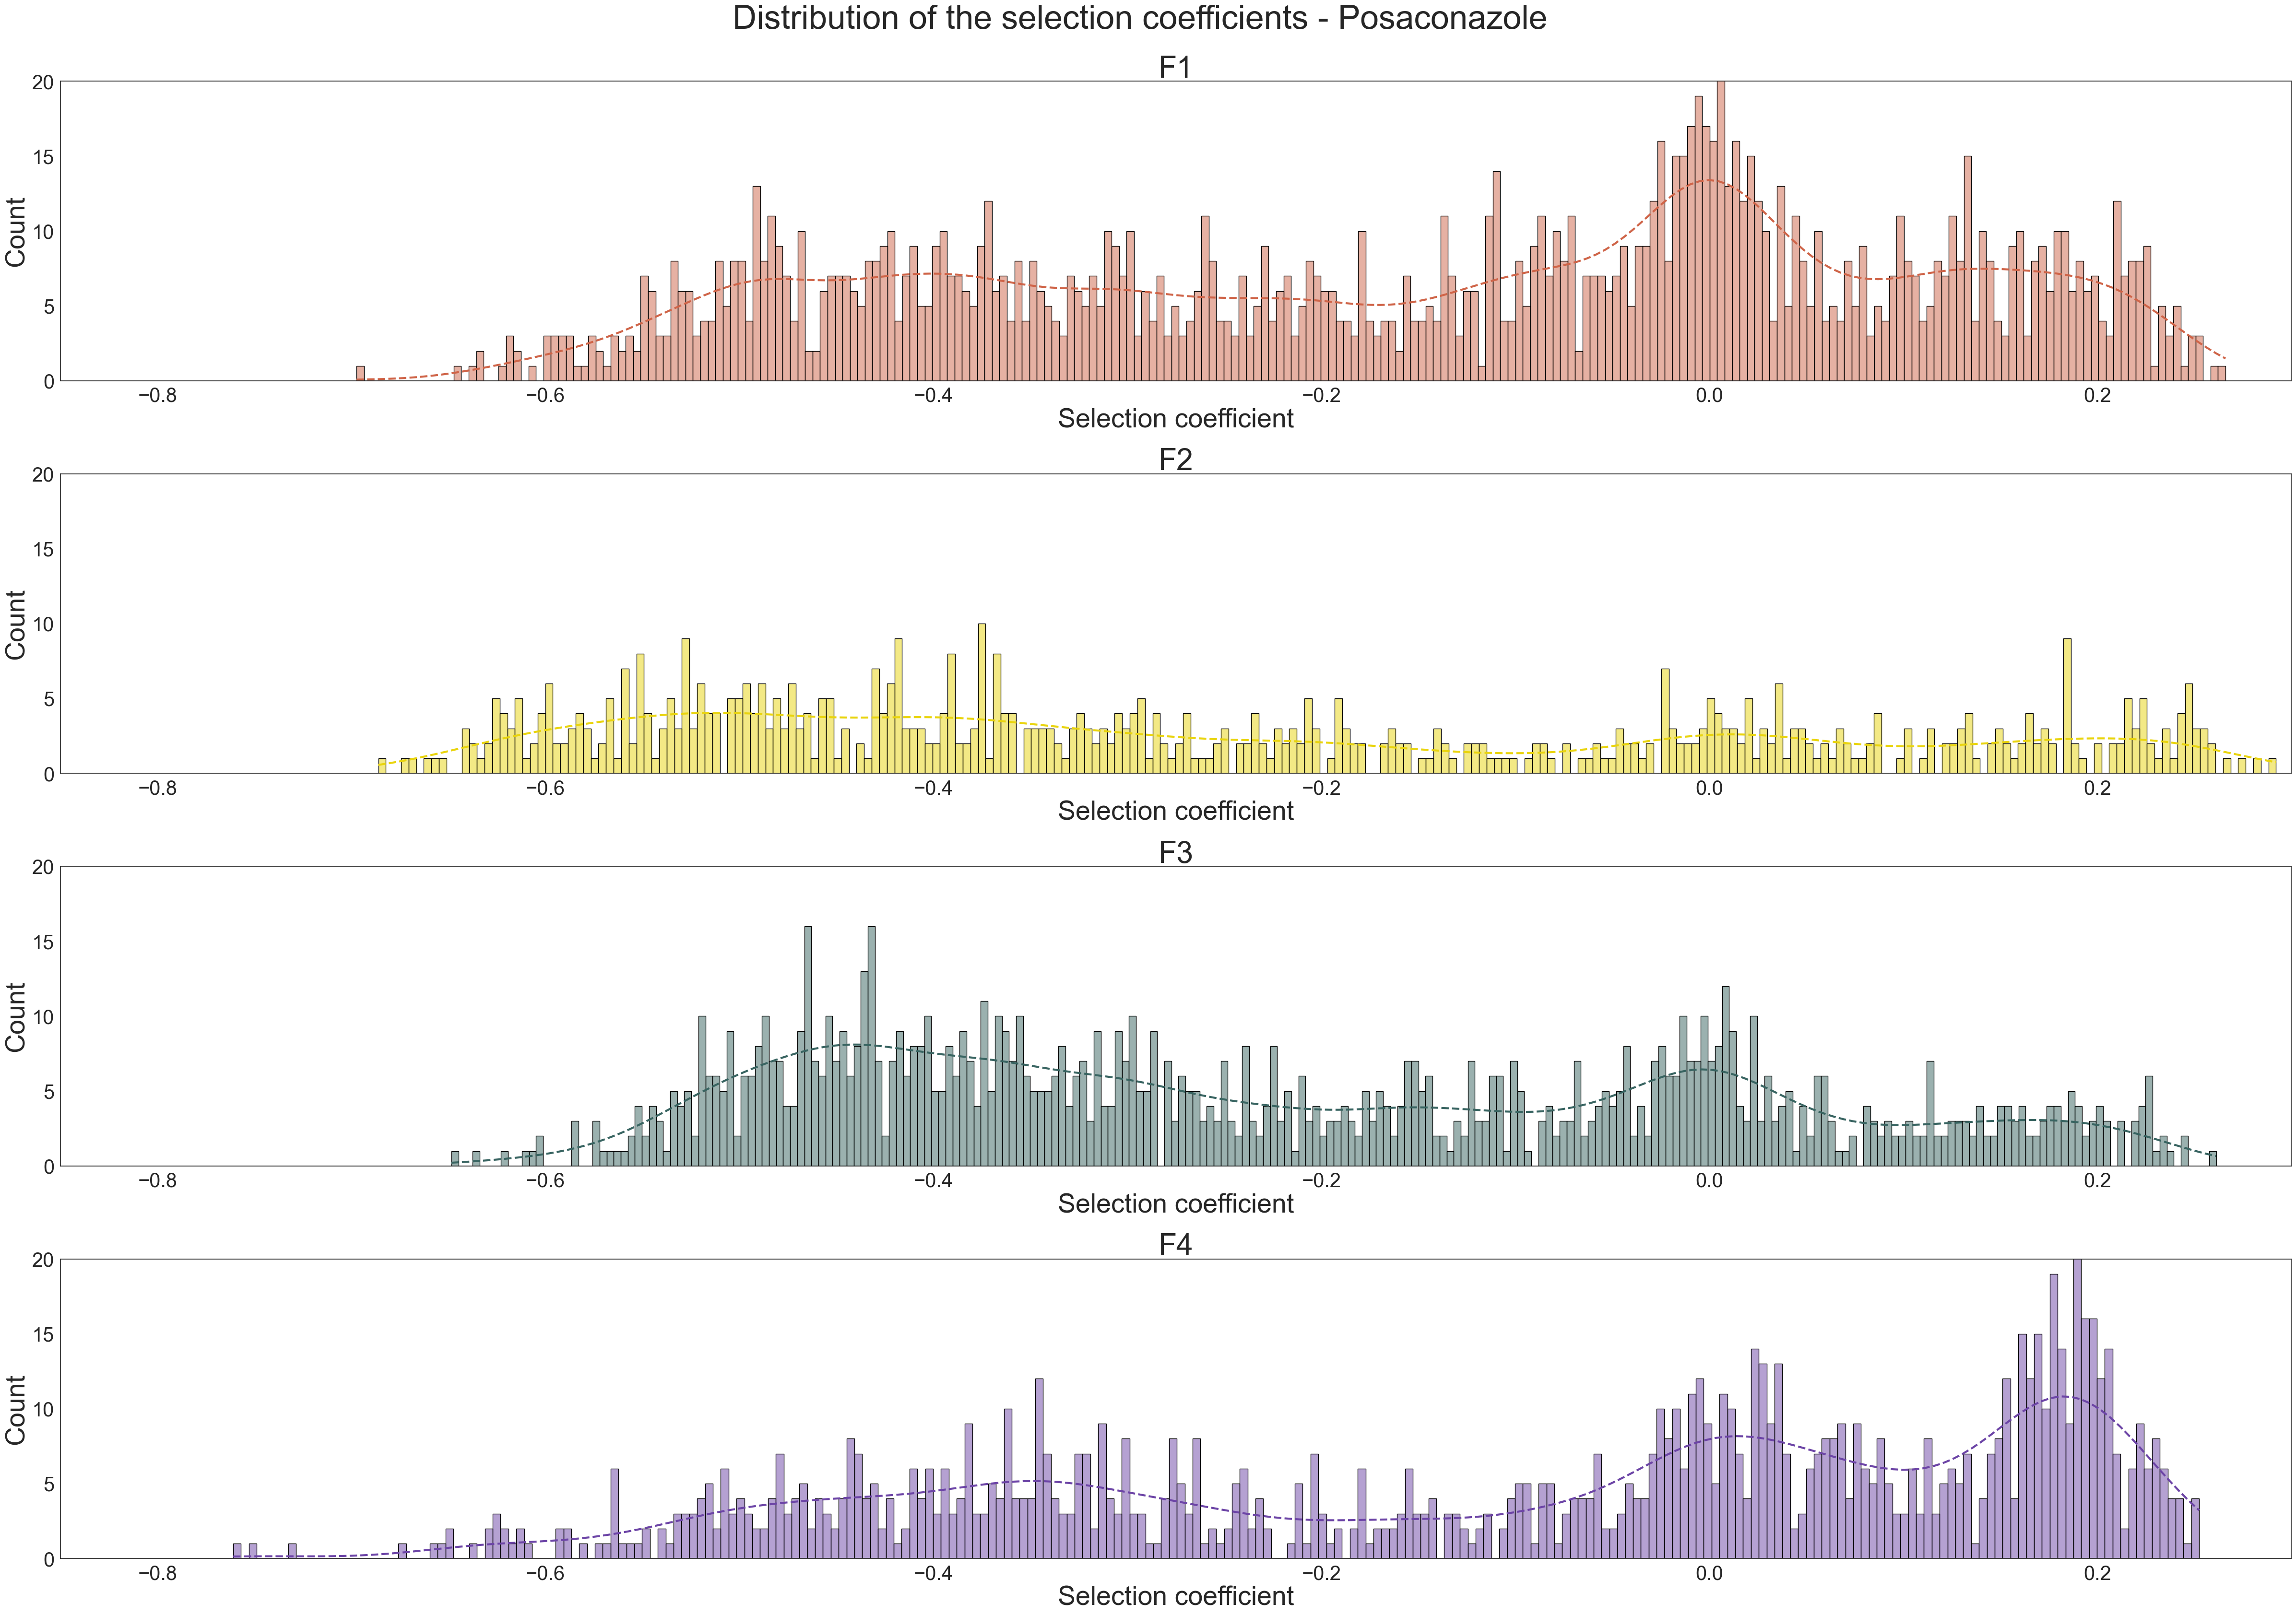

In [93]:
#Distribution of the selection coefficient

df_o_F = df_o.groupby("Fragment")

f_list = ["F1","F2","F3","F4"]
color_list = ["#CF6448","#E9D40D","#386461","#6C44A6"]
row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(4, 1, figsize=(60,40))
axes = axes.flatten()
 
for frag in f_list :
    
    df = df_o_F.get_group(frag)
    
    sns.set_theme(style="white")
    
    sns.histplot(x=df["select_coef"], edgecolor="black", color = color_list[row],  bins = 250,kde=True, kde_kws = {'bw_adjust': 0.5},ax = axes[row], 
                 line_kws = {'linestyle':'dashed','linewidth':'3'}).lines[0].set_color(color_list[row])

    axes[row].set_ylim(0, 20)
    axes[row].set_xlim(-0.85, 0.3)
    
    axes[row].set_ylabel("Count",fontsize=40)
    axes[row].set_xlabel("Selection coefficient",fontsize=40)
    
    axes[row].set_title(frag, fontsize=45)
    
    axes[row].tick_params(labelsize = 30)  
    
    row += 1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Distribution of the selection coefficients - ' + condition, y=0.92, fontsize=50)

name = "Distribution_of_the_selection_coefficient_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

In [94]:
#put rows in overlaps in a new df

df_new = pd.DataFrame(columns=["index", 'position', 'aa', 'Antifungal', 'Fragment', "l2fc_0_2", "l2fc_0_3", "select_coef", "l2fc_0_2_norm", "l2fc_0_3_norm", "select_coef_norm"])

for _, row in df_o.iterrows():
    position = row['position']
    fragment = row['Fragment']
    
    if position in f3_f4_over and fragment == "F3":
        row['Fragment'] = "F3_4"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F2":
        row['Fragment'] = "F2_3"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F3":
        row['Fragment'] = "F3_2"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f1_f2_over and fragment == "F2":
        row['Fragment'] = "F2_1"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in over_list:
        df_new = df_new.append(row, ignore_index=True)
        
df_new = df_new.reset_index().drop("index",axis=1).drop("level_0",axis=1)

C:\Users\CABED117\AppData\Local\Temp\ipykernel_35336\2685448605.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_35336\2685448605.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_35336\2685448605.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_35336\2685448605.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_

In [95]:
df_group = df_new.groupby(["Fragment"])

f1 = df_group.get_group("F1").reset_index()
f2_1 = df_group.get_group("F2_1").reset_index()
f2_3 = df_group.get_group("F2_3").reset_index()
f3_2 = df_group.get_group("F3_2").reset_index()
f3_4 = df_group.get_group("F3_4").reset_index()
f4 = df_group.get_group("F4").reset_index()

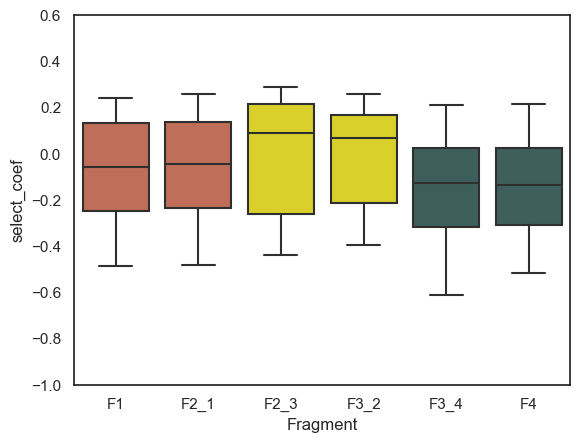

In [96]:
sns.set_theme(style="white")

custom_palette = sns.blend_palette(["#CF6448","#CF6448","#F6EA0E","#F6EA0E","#386461","#386461"], n_colors=6)
sns.boxplot(data= df_new, x= "Fragment", y = "select_coef", palette = custom_palette)
plt.ylim(-1, 0.6)

name = "Boxplot_overlaps_med_select_coef_" + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

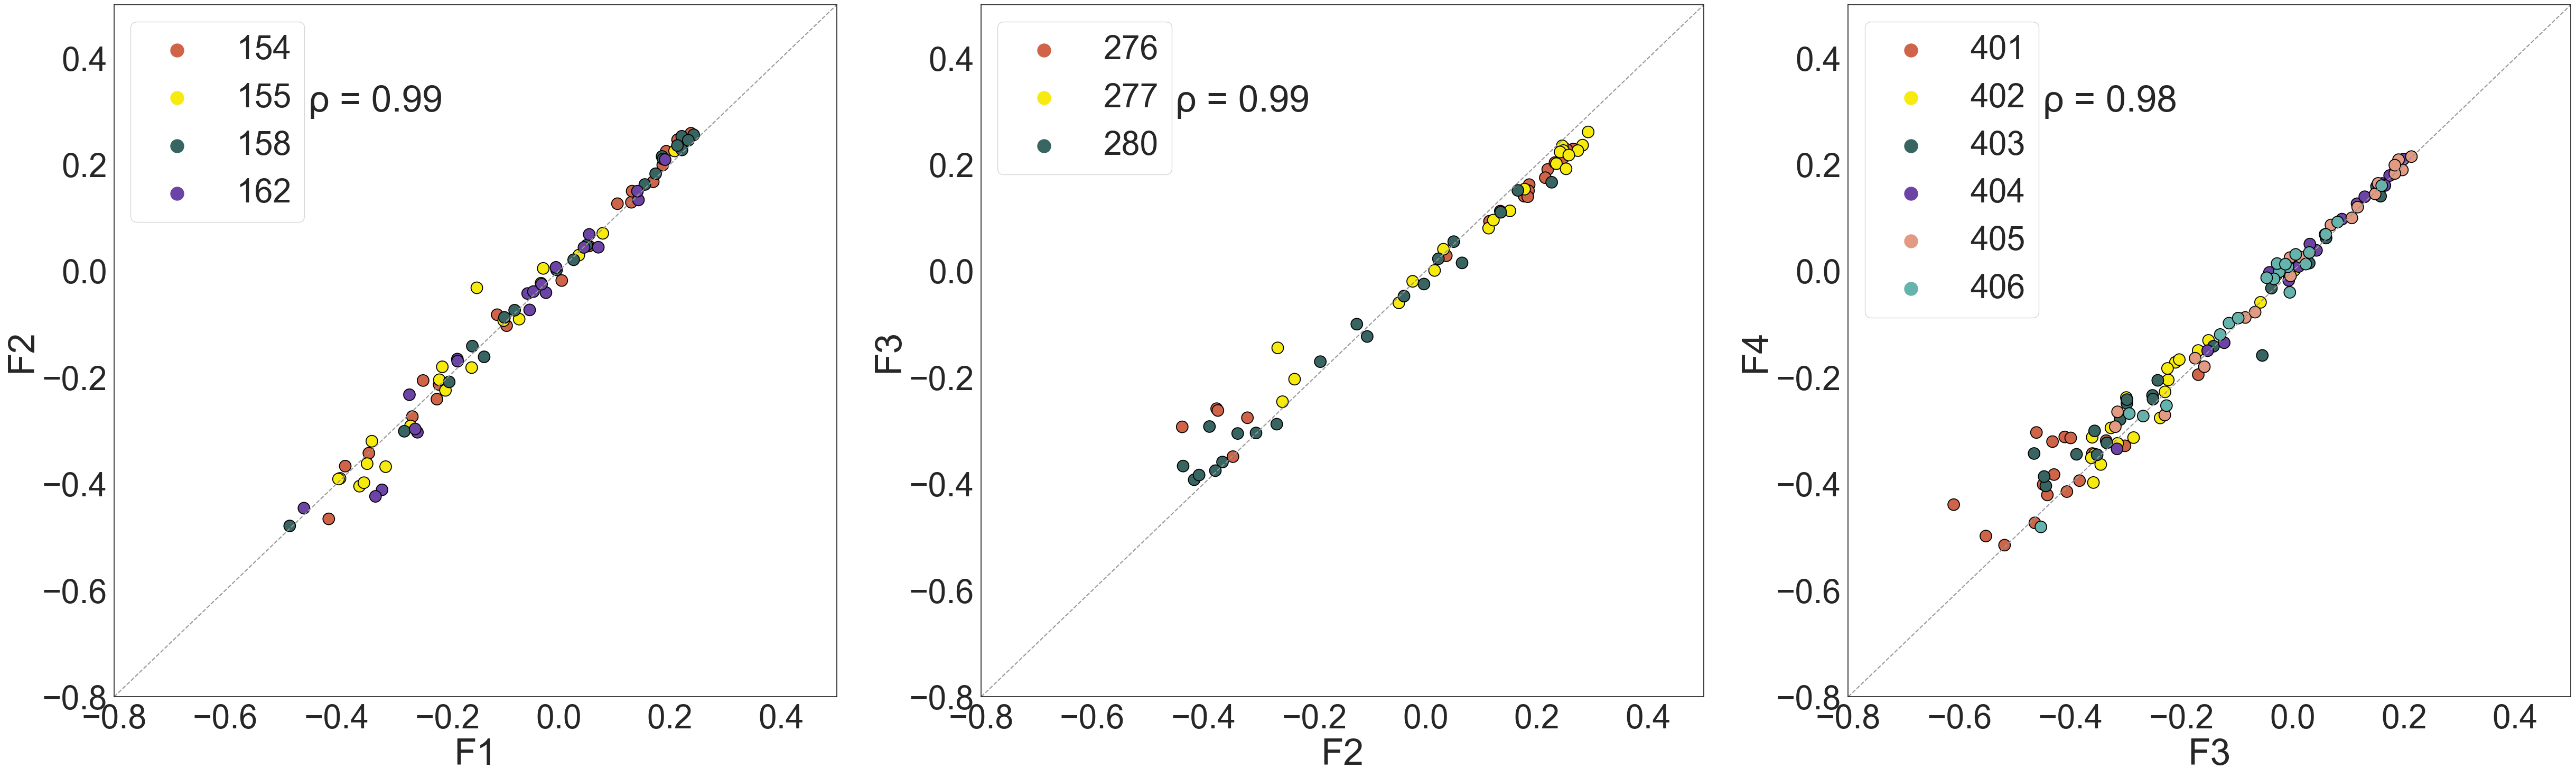

In [97]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")

o1_list = ["f1","f2_3","f3_4"]

o2_list = ["f2_1","f3_2","f4"]

title_name = ["F1 and F2","F2 and F3","F3 and F4"]
x_name = ["F1", "F2", "F3"]
y_name = ["F2", "F3", "F4"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(len(o1_list)) :
    
    name1 = o1_list[i]
    df1 = globals()[name1]
    
    name2 = o2_list[i]
    df2 = globals()[name2]
    
    sns.set_theme(style="white")
    
    custom_palette = sns.color_palette(["#CF6448","#F6EA0E","#386461","#6C44A6","#E29B82","#64B3AC"], n_colors=len(df1["position"].unique()))
    
    sns.scatterplot(x=df1["select_coef"],  y=df2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = df1["position"],s = 250, ax = axes[row])    
    
    axes[row].set_ylabel(y_name[i], fontsize=50)
    axes[row].set_xlabel(x_name[i], fontsize=50)
    
    #axes[row].set_title(title_name[i], fontsize=55)
    
    axes[row].set_ylim(-0.8, 0.5)
    axes[row].set_xlim(-0.8, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-0.8, 0.5])
    y_vals = x_vals
    
    result = sp.stats.spearmanr(df1["select_coef"],df2["select_coef"])
    coeff = result[0]
    p_value = result[1]
    R2 = coeff**2 
    
    text = "ρ = " + str(round(coeff, 2)) #+ "\nP = " + str(round(p_value, 5))
    axes[row].text(-0.45,0.3, text , fontsize = 50)

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
        
    row +=1
    
fig.subplots_adjust(hspace=0.31)



plt.rcParams['svg.fonttype'] = 'none'
name = "Overlap_select_coef_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [111]:
#Getting the means of the overlapping positions

#norm_df = norm_df.drop('Fragment', axis=1)

df_group = df_o.groupby(["position","aa","Antifungal"])
cols = ["select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal"])

name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name) 

# 8- Heatmaps and figures !!

In [112]:
name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_f = pd.read_csv(name, header=0, index_col = 0)

In [113]:
WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0, index_col = 0)

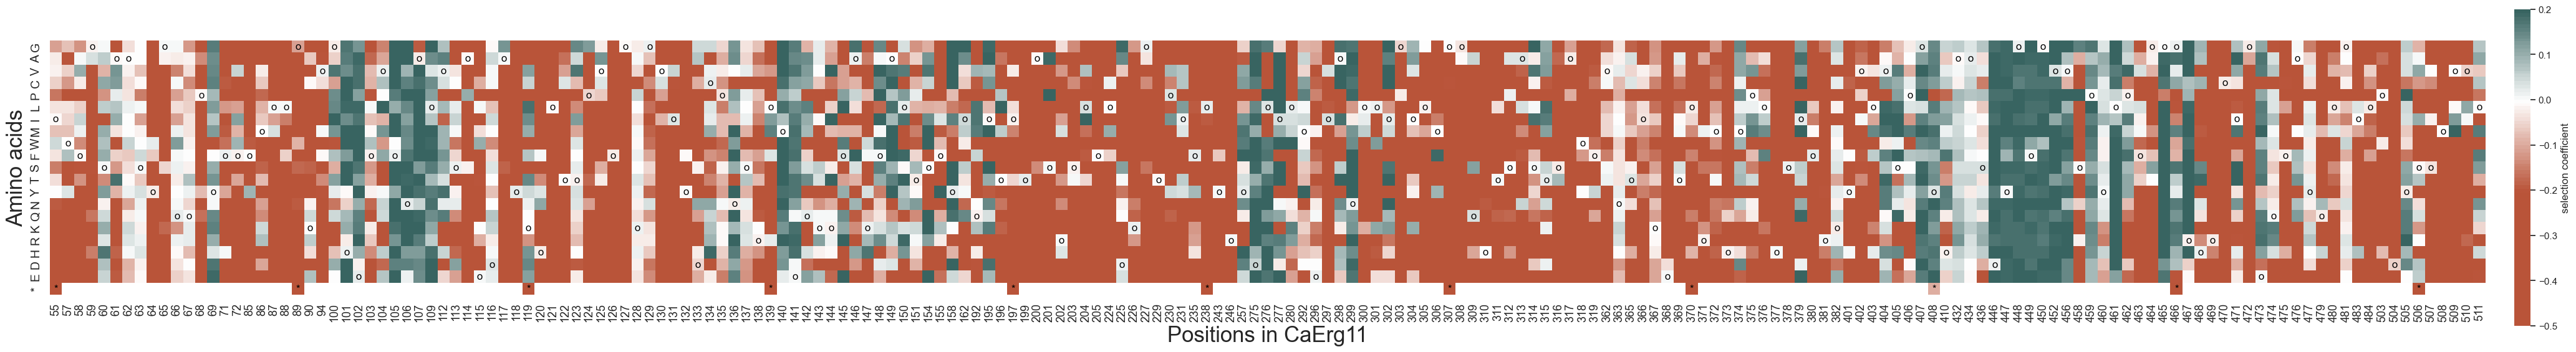

In [114]:
heat = pd.pivot_table(df_f, index="aa", columns= "position", values="select_coef")

heat = heat.reindex(index = ["G","A","V","C","P","L","I","M","W","F","S","T","Y","N","Q","K","R","H","D","E","*"])

custom_palette = sns.blend_palette(["#B95439","#B95439","#B95439","#FFFFFF","#386461"], n_colors=101)

plt.subplots(figsize=(60,60))
sns.set(rc={'figure.facecolor':'white'})
#sns.set(font_scale=1.5)

sns.heatmap(heat, xticklabels="auto", yticklabels=True, annot=False, cmap = custom_palette, 
            robust = True,square=True,  vmin=-0.5, vmax=0.2,center=-0.2, 
            cbar_kws={"shrink": 0.11,"pad": 0.01,'label': 'selection coefficient'})

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=13)

for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        if WT_annot.iloc[i, j] == "o" or WT_annot.iloc[i, j] == "*":
            plt.text(j + 0.5, i + 0.5, WT_annot.iloc[i, j], ha='center', va='center', fontsize=12, color='black')
        
#titre = f"Selection coefficients - {condition} Screening - Library Erg11 of " + '$\it{Candida}$' +" "+ '$\it{albicans}$'

#plt.title(titre, fontsize =30)

plt.xlabel('Positions in CaErg11', fontsize = 25)
plt.ylabel('Amino acids', fontsize = 25)

plt.rcParams['svg.fonttype'] = 'none'
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".png"
plt.savefig(name, transparent=True, dpi=750,format='png', bbox_inches='tight')
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".svg"
plt.savefig(name, transparent=True, dpi=300,format='svg', bbox_inches='tight')

# 9- t-test significant resistance

In [99]:
#import the df with the replicates, replicates are needed for t tests
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date + ".csv"

df_t = pd.read_csv(name, header=0)

In [100]:
# Add a new column with the translation
df_t['aa'] = df_t['codon'].map(DNA_Codons)
df_t['DNA_variant'] =df_t['position'].astype(str) + df_t['codon']
df_t['aa_variant'] =df_t['position'].astype(str) + df_t['aa']

In [101]:
Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [102]:
# get all the wts infos in our df fluco

df_wt = df_t  # Assigning merged_df to df_wt

ite = 0  # Initializing a counter variable

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    else :   
        df_t.loc[ite,"aa_variant"] = "WT"
        
    ite = ite + 1  # Incrementing the counter variable
    
df_wt = df_wt.drop("level_0",axis=1).reset_index()

In [103]:
# Perform t-tests for each variant
variants = df_t['aa_variant'].unique()
results = []

for variant in variants:
    variant_data = df_t[df_t['aa_variant'] == variant]

    anti_data = variant_data[variant_data['Antifungal'] == cond]['select_coef']
    wt_data = df_t[df_t['aa_variant'] == 'WT']['select_coef']
    t_stat, p_value = ttest_ind(anti_data, wt_data)
    
    results.append((variant, p_value))

# Apply FDR correction to the p-values decause I am doing multiple comparaison
_, adjusted_p_values, _, _ = multipletests([p_value for _, p_value in results], method='fdr_bh')

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['aa_variant', 'p_value'])
results_df['adjusted_p_value'] = adjusted_p_values

# View the results
print(results_df)

     aa_variant        p_value  adjusted_p_value
0           55K   2.105540e-73      4.742108e-73
1           55N   1.877155e-42      3.216182e-42
2           55T   1.475112e-04      1.696534e-04
3           55R   4.639558e-97      1.218242e-96
4            WT   1.000000e+00      1.000000e+00
...         ...            ...               ...
3826       511Y  1.258176e-101     3.423348e-101
3827       511S   1.599879e-22      2.260840e-22
3828       511C   6.358439e-09      7.819962e-09
3829       511W   1.351608e-28      2.029796e-28
3830       511F   2.785387e-38      4.554340e-38

[3831 rows x 3 columns]


In [104]:
# Merge the variant results 
anti_merged = df_t.merge(results_df, on=['aa_variant'], how='left')

In [105]:
df_group = anti_merged.groupby(["position","Antifungal","aa"])
cols = ["select_coef","p_value","adjusted_p_value"]
med_anti = df_group[cols].median()

#reset index so the index becomes columns again
med_anti = med_anti.reset_index(level=["position","Antifungal","aa"])
med_anti['aa_variant'] =med_anti['position'].astype(str) + med_anti['aa']

In [106]:
advantageous = []
wt_like = []
deleterious = []
df_del = pd.DataFrame(columns=['select_coef', 'aa_variant', 'result'])

for i in range(len(med_anti)):
    if med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] > 0:
        advantageous.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Advantageous"
    elif med_anti.loc[i,"adjusted_p_value"] > 0.01 :
        wt_like.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "WT like"
    elif med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] < 0:
        deleterious.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Deleterious"

In [107]:
print(str(len(advantageous)) + " variant have an advantage")
print(str(len(deleterious)) + " variant have a deleterious substitution")
print(str(len(wt_like)) + " variant are like the WT without antifungal")

1011 variant have an advantage
2470 variant have a deleterious substitution
541 variant are like the WT without antifungal


In [108]:
df_del_g = df_del.groupby("result")
df_del_wt = df_del_g.get_group("WT like")
#df_del_wt["select_coef"].max()
#df_del_wt["select_coef"].min()
df_del_wt["select_coef"].quantile(0.95)
#df_del_wt["select_coef"].quantile(0.05)

0.0314180683812385

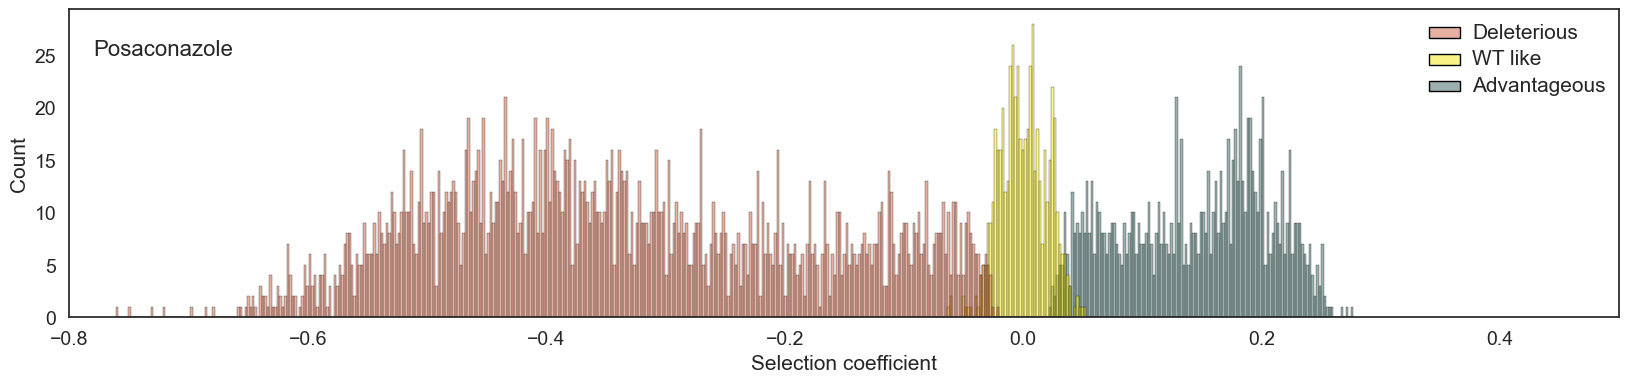

In [109]:
sns.set_style("white")
sns.set_theme(style="white", palette=None)

plt.subplots(figsize=(20, 4))
custom_palette = sns.blend_palette(["#CF6448", "#F6EA0E", "#386461"], n_colors=3)

plot = sns.histplot(data=df_del, x="select_coef", edgecolor="black", hue="result", palette=custom_palette, bins=500)

legend = plot.get_legend()  
legend.set_title("", prop={"size": 16} ) 
legend.set_frame_on(False)
for label in legend.get_texts():  
    label.set_size(15)  
    
plt.xlim(-0.8, 0.5)
#plt.title(condition + " - distribution of the selection coefficient", fontsize=20)

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)

plt.xlabel('Selection coefficient', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

plt.text(-0.78,25, condition , fontsize = 16)
    
plt.rcParams['svg.fonttype'] = 'none'
name = "Distribution_" + "select_coef_t-test_results_" + condition + "_" +experiment + "_" + date 
plt.savefig(name+ ".png", transparent=True, dpi=750,format='png', bbox_inches='tight')
plt.savefig(name+ ".svg", transparent=True, dpi=750,format='svg', bbox_inches='tight')

In [110]:
#med_anti = med_anti.drop(["level_0","index"], axis=1)
med_anti = med_anti.rename(columns={"aa_variant": "variant"})
name = "Select_coeff_p_value_aa_" + condition + "_" + experiment + "_" + date + ".csv"
med_anti.to_csv(name) 

med_anti

position Antifungal aa  select_coef        p_value  adjusted_p_value  \
0           55     Posaco  *    -0.456467  7.714851e-109     2.212245e-108   
1           55     Posaco  A    -0.025771   2.423459e-02      2.639827e-02   
2           55     Posaco  C    -0.059051   1.480378e-05      1.726958e-05   
3           55     Posaco  D    -0.349018  2.893037e-117     8.945299e-117   
4           55     Posaco  E    -0.351371  8.040253e-122     2.584078e-121   
...        ...        ... ..          ...            ...               ...   
4017       511     Posaco  S     0.127347   1.599879e-22      2.260840e-22   
4018       511     Posaco  T    -0.095493   8.008426e-15      1.049257e-14   
4019       511     Posaco  V    -0.068628   3.179788e-09      3.934679e-09   
4020       511     Posaco  W    -0.210768   1.351608e-28      2.029796e-28   
4021       511     Posaco  Y    -0.321284  1.258176e-101     3.423348e-101   

     variant  
0        55*  
1        55A  
2        55C  
3        55D  
4        55E  
...      ...  
4017    511S  
4018    511T  
4019    511V  
4020    511W  
4021    511Y  

[4022 rows x 7 columns]